In [1]:
metrics_df_lst = []
#{"experiment_num": "", "model_type": "", "train_mae": 0, "val_mae": 0, "perc_lt_5mins": 0, "perc_lt_10mins": 0 }

In [2]:
import numpy as np
import pandas as pd

collect_created_at_df = pd.read_csv("fulfillment_data/new/_SELECT_collects_id_COUNT_orders_id_collects_created_at_users_wa.csv", sep=";")
cols = list(collect_created_at_df.columns)
cols[1] = "num_orders"
cols[0] = "collect_id"
collect_created_at_df.columns = cols

import pandas as pd
collection_to_orders_df = pd.read_csv("fulfillment_data/new/_SELECT_collects_id_orders_id_COUNT_product_order_id_AS_products.csv", sep=";")

order_collects_df = collection_to_orders_df.merge(collect_created_at_df, on="collect_id")
order_collects_df.rename(columns={"warehouse_name_x": "warehouse_name"}, inplace=True)
del order_collects_df["warehouse_name_y"]

order_list_df = pd.read_csv("fulfillment_data/new/_SELECT_orders_id_AS_order_id_product_order_product_id_AS_produc.csv", sep=";")

products_list_df = pd.read_csv("fulfillment_data/new/_Select_products_id_sku_code_products_name_volume_place_users_wa.csv",encoding= 'windows-1251', sep=";")


from datetime import timedelta

import matplotlib.pyplot as plt



### Keep only where needed warehouse (5)

In [3]:
order_collects_df = order_collects_df[order_collects_df["warehouse_name"] == 5]

order_list_df = order_list_df[order_list_df["warehouse_name"] == 5]

products_list_df.rename(columns={"id": "product_id"}, inplace=True)

### Time filtering

In [4]:
order_collects_df["created_at"] = pd.to_datetime(order_collects_df["created_at"])
order_collects_df["collect_date"] = pd.to_datetime(order_collects_df["collect_date"])

order_collects_df["collect_time"] = order_collects_df["collect_date"] - order_collects_df["created_at"]



<AxesSubplot:>

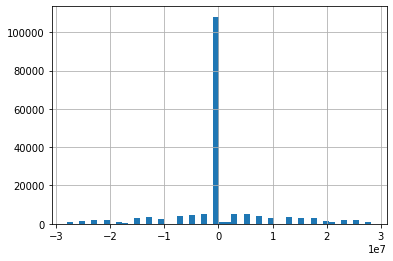

In [5]:
order_collects_df["collect_time"].dt.total_seconds().hist(bins=50)

 **remove where negative collect time**

In [6]:
collect_ids_to_del = set(order_collects_df[order_collects_df["collect_time"] < timedelta(seconds = 0)]["collect_id"].unique())


from datetime import timedelta
order_collects_df = order_collects_df[~order_collects_df["collect_id"].isin(collect_ids_to_del) ]

collect_id_to_approx_sorting_started = dict(order_collects_df.groupby("collect_id")["collect_date"].apply(min))

collect_id_to_orders_sorting_ended_list = dict(order_collects_df.groupby("collect_id")["collect_date"].apply(list))

order_collects_df["approx_store_walk_end"] = order_collects_df.apply(lambda row: collect_id_to_approx_sorting_started[row["collect_id"]] , axis = 1)


order_collects_df["approx_store_walk_time"] = order_collects_df["approx_store_walk_end"] - order_collects_df["created_at"]

def get_approx_sorting_time_for_this_order(row):
    
    cur_time = row["collect_date"]
    
    cur_collect_times = sorted(collect_id_to_orders_sorting_ended_list[row["collect_id"]], reverse=True)
    
    for t in cur_collect_times:
        if t < cur_time:
            return cur_time - t
        
    return timedelta(seconds = 0)

## NOTE time_order_sorted is inaccurate for cases where order was collected in same minute

order_collects_df["time_order_sorted"] = order_collects_df.apply(lambda row: get_approx_sorting_time_for_this_order(row), axis=1)




**Collects THAT TOOK MORE THAN 3 HOURS TO WALK IN STORE ARE OUTLIERS (2384 out of 8385)**

Note: domain expert told that walking in store that took more than 3 hours could be deleted

In [7]:
order_collects_df[order_collects_df["approx_store_walk_time"] > timedelta(hours=3)]["collect_id"].nunique()

order_collects_df[order_collects_df["approx_store_walk_time"] < timedelta(hours=3)]["approx_store_walk_time"].mean()

collects_to_del = list(order_collects_df[order_collects_df["approx_store_walk_time"] > timedelta(hours=3)]["collect_id"].unique())

collects_to_del += list(order_collects_df[order_collects_df["approx_store_walk_time"] < timedelta(seconds=30)]["collect_id"].unique())

collects_to_del += [14387, 13648, 14360]

order_collects_df = order_collects_df[~order_collects_df["collect_id"].isin(collects_to_del)]



**Collects THAT TOOK MORE THAN 3 HOURS TO SORT ARE OUTLIERS**

In [8]:
collect_id_to_collect_sorting_ended = dict(order_collects_df.groupby("collect_id")["collect_date"].apply(max))

order_collects_df['collect_sort_time'] = order_collects_df.apply(lambda row: collect_id_to_collect_sorting_ended[row["collect_id"]] - row["approx_store_walk_end"] , axis = 1)

order_collects_df = order_collects_df[order_collects_df["collect_sort_time"] < timedelta(hours=3)]

## Products locations fix

In [9]:
needed_warehouse_names = ["MTP", "5", "5A"]

products_list_df = products_list_df[products_list_df['warehouse_name'].isin(needed_warehouse_names)]

products_list_df = products_list_df[~products_list_df["place"].isna()]
products_list_df = products_list_df[products_list_df["place"] != '0']

def place_str_to_info_lst(place_str):
    
    if str(place_str) == "nan":
        return []
    
    replace_dict = dict([('О','0'), ('И','B') , ('С','C'), ('A','A'), ('А','A'), ('В','B'), ('Е','E'), ('Х','X'), ('Д','D'), ('*','-'), ('\'', "")])
    place_str = place_str.upper()
    for k in replace_dict.keys():
        place_str = place_str.replace(k, replace_dict[k])
    
    #place_str = place_str.upper().replace('О','0').replace('С','C').replace('A','A').replace('А','A').replace('В','B').replace('Е','E').replace('Х','X').replace('Д','D').replace('*','-').replace('\'', "")
    place_lst = list(filter(lambda x: x ,place_str.split(',')))
    place_lst_2 = []
    for p in place_lst:
        place_lst_2 += [x.strip() for x in p.split('/')]
    place_lst = place_lst_2
    place_lst_3 = []
    for p in place_lst:
        place_lst_3 += [x.strip() for x in p.split('.')]
    place_lst = place_lst_3 
    place_lst_4 = []
    for p in place_lst:
        place_lst_4 += [x.strip() for x in p.split('|')]
    place_lst = place_lst_4
    place_lst_5 = []
    for p in place_lst:
        place_lst_5 += [x.strip() for x in p.split('  ')]
    place_lst = place_lst_5
    place_lst_6 = []
    for p in place_lst:
        place_lst_6 += [x.strip() for x in p.split('\\')]
    place_lst = place_lst_6
    
    
    
        
    place_lst = [x.replace('/', '').replace('\\','').replace('`','').strip() for x in place_lst]
    new_place_lst = []
    for x in place_lst:
        if x.startswith('-'):
            x = x[1:]
            
        if len(x)>2 and x[0].isalpha() and x[1].isalpha():
            x = x[0] + x[2:]
        if len(x)>=2 and x[0].isalpha() and x[1].isnumeric():
            x = x[0] + "-"+ x[1:]
            
        x_new_lst = []
        for part in x.split('-'):
            part = part.strip()
            
            if part.isnumeric():
                x_new_lst.append(str(int(part)))
            else:
                x_new_lst.append(part)
        
        
        x = "-".join(x_new_lst)
        
        
        new_place_lst.append(x)
        
    new_place_lst1 = []
    
    for l in new_place_lst:
        new_place_lst1 += l.split()
        
    new_place_lst2 = []
        
    for x in new_place_lst1:
        
        if any([let.isalpha() for let in x[1:]]):
            for ind, letalpha in enumerate([let.isalpha() for let in x[1:]]):
                if letalpha:
                    new_place_lst2.append(x[:ind + 1])
                    new_place_lst2.append(x[ind + 1:])
        else:
            new_place_lst2.append(x)

    
    new_place_lst2 = list(filter(lambda x: sum([l.isalpha() for l in x]) < 2,new_place_lst2))
    new_place_lst2 = list(filter(lambda x: len(x) > 2,new_place_lst2))
    
    
    new_place_lst = []
    for x in new_place_lst2:
        if x.startswith('-'):
            x = x[1:]
            
        if x.endswith('-') or x.endswith('(') or x.endswith(')') :
            x = x[:-1]

            
        if len(x)>2 and x[0].isalpha() and x[1].isalpha():
            x = x[0] + x[2:]
        if len(x)>2 and x[0].isalpha() and x[1].isnumeric():
            x = x[0] + "-"+ x[1:]
            
        x_new_lst = []
        for part in x.split('-'):
            part = part.strip()
            
            if part.isnumeric():
                if int(part) > 100: # DELETE x
                    x = ""
                x_new_lst.append(str(int(part)))
            else:
                x_new_lst.append(part)
        
        
        x = "-".join(x_new_lst) if x else x
        
        x_split = x.split('-')
        
        if len(x_split) >= 2 and x_split[0].isnumeric() and "(" in x_split[1]:
            x = x_split[0] + "-".join(x_split[1:])
    
        
        if x and x[-1].isalpha():
            x = x[:x.find('(')]
            
        if x.startswith('('):
            x = ''
        
        if "G" in x:
            if x == "G-5":
                x = "71(1)-4"
            else:
                x = ''
                
        if "X-0" in x:
            x = x.replace("X-0", "X")
        
        if x:
            new_place_lst.append(x)
        
    
    
    return new_place_lst

products_list_df["cleaned_place"] = products_list_df.apply(lambda row: place_str_to_info_lst(row["place"]),axis=1)


def shorten_place(p):
    if (p[0].isalpha()) and (p.count('-') >= 3):
        i = p.rfind('-')
        return p[:i]
    elif (not p[0].isalpha()) and (p.count('-') >= 2):
        i = p.rfind('-')
        return p[:i]
    else:
        return p

products_list_df["short_cleaned_place"] = products_list_df.apply(lambda row: [shorten_place(p) for p in row["cleaned_place"]],axis=1)

def get_place_componenents(p):
    
    # note: X is for refrigirator. Lets consider it has 1 cell and 1 level
    # because we only have 1 refrigerator
    if "X" in p:
        return {"cell": "X", "level": 1}
    
    p_split = p.split('-')
    level = None
    cell = None
    
    if p[0].isnumeric():
        cell = p_split[0]
        if len(p_split) >= 2:
            level = int(p_split[1])
        else:
            level = 1
            
    else:
        cell = p_split[0] + "-" + p_split[1]
        if len(p_split) > 2:
            level = p_split[2]
        else:
            level = 1
    
    return {"cell": cell, "level": level}

products_list_df["place_cell"] = products_list_df.apply(lambda row: [get_place_componenents(x)["cell"] for x in row["short_cleaned_place"]],axis=1)
products_list_df["place_level"] = products_list_df.apply(lambda row: [get_place_componenents(x)["level"] for x in row["short_cleaned_place"]],axis=1)

# some of them are 0 (if they are bad) so remove them

products_list_df = products_list_df[products_list_df["short_cleaned_place"].str.len() != 0]



new_unique_places = set()
for p in sorted(list(products_list_df[~products_list_df["place"].isna()]["place"].unique())):
    place_lst = place_str_to_info_lst(p)
    new_unique_places.update(place_lst)
    
new_unique_places = list(new_unique_places)



## Keep only orders with products that are present in dataset (so they are in needed warehouse)

In [10]:
needed_prod_ids = set(list(products_list_df["product_id"].unique()))

order_id_to_prod_ids = dict(order_list_df.groupby("order_id")["product_id"].apply(set))

needed_order_ids = set()

for oid in order_id_to_prod_ids.keys():
    if len(needed_prod_ids.intersection(order_id_to_prod_ids[oid])) == len(order_id_to_prod_ids[oid]):
        needed_order_ids.add(oid)
        
order_list_df = order_list_df[order_list_df["order_id"].isin(needed_order_ids)]

products_list_df = products_list_df[products_list_df["product_id"].isin(list(order_list_df["product_id"].unique()))]

collect_id_to_order_ids = dict(order_collects_df.groupby("collect_id")["order_id"].apply(set))

needed_collect_ids = set()

for cid in collect_id_to_order_ids.keys():
    if len(needed_order_ids.intersection(collect_id_to_order_ids[cid])) == len(collect_id_to_order_ids[cid]):
        needed_collect_ids.add(cid)
        
order_collects_df = order_collects_df[order_collects_df["collect_id"].isin(needed_collect_ids)]

order_list_df = order_list_df[order_list_df["order_id"].isin(set(order_collects_df["order_id"].unique()))]





## KEEP COLLECTS WITH 1-2 ORDERS

In [11]:
gb = order_collects_df.groupby("collect_id")["order_id"].nunique() < 3
collect_id_to_del = list(gb[gb == True].index) # to del actually is to keep )


In [12]:
len(collect_id_to_del)


1230

In [13]:
order_collects_df["collect_id"].nunique()


3097

In [14]:
1230 / 3100


0.3967741935483871

In [15]:
order_collects_df = order_collects_df[order_collects_df["collect_id"].isin(collect_id_to_del)]

# Keep only orders with products that are present in dataset again

In [16]:


needed_prod_ids = set(list(products_list_df["product_id"].unique()))

order_id_to_prod_ids = dict(order_list_df.groupby("order_id")["product_id"].apply(set))

needed_order_ids = set()

for oid in order_id_to_prod_ids.keys():
    if len(needed_prod_ids.intersection(order_id_to_prod_ids[oid])) == len(order_id_to_prod_ids[oid]):
        needed_order_ids.add(oid)
        
order_list_df = order_list_df[order_list_df["order_id"].isin(needed_order_ids)]

products_list_df = products_list_df[products_list_df["product_id"].isin(list(order_list_df["product_id"].unique()))]

collect_id_to_order_ids = dict(order_collects_df.groupby("collect_id")["order_id"].apply(set))

needed_collect_ids = set()

for cid in collect_id_to_order_ids.keys():
    if len(needed_order_ids.intersection(collect_id_to_order_ids[cid])) == len(collect_id_to_order_ids[cid]):
        needed_collect_ids.add(cid)
        
order_collects_df = order_collects_df[order_collects_df["collect_id"].isin(needed_collect_ids)]

order_list_df = order_list_df[order_list_df["order_id"].isin(set(order_collects_df["order_id"].unique()))]

In [17]:
order_collects_df["collect_id"].nunique()


1230

# Select model for approximation of time spent on walking

Target: approx_store_walk_time

In [18]:
oid_to_prod_quantity_default = dict(order_collects_df.groupby("order_id")["products_quantity"].sum())

oid_to_prod_quantity_manual = dict(order_list_df.groupby("order_id")["product_id"].nunique())


oid_to_prod_lst = dict(order_list_df.groupby("order_id")["product_id"].apply(set))

cid_to_oids = dict(order_collects_df.groupby("collect_id")["order_id"].apply(set))

cid_to_prod_quantity_unique = {}

for cid in cid_to_oids.keys():
    unique_prods = set()
    for oid in list(cid_to_oids[cid]):
        unique_prods.update(oid_to_prod_lst[oid])
    
    
    cid_to_prod_quantity_unique[cid] = len(unique_prods)
    
    

prod_quantity_default = []
prod_quantity_manual = []

for k in oid_to_prod_quantity_manual.keys():
    prod_quantity_default.append(oid_to_prod_quantity_default[k])
    prod_quantity_manual.append(oid_to_prod_quantity_manual[k])
    
    
order_collects_df["products_quantity_unique"] = order_collects_df.apply(lambda row: oid_to_prod_quantity_manual[row["order_id"]],axis=1)

order_collects_df["products_quantity_unique_in_collect"] = order_collects_df.apply(lambda row: cid_to_prod_quantity_unique[row["collect_id"]],axis=1) 




products_quantity - total number of products in order (considering some prods may appear several time in the order)

products_quantity_unique - number of unique products in order

products_quantity_unique_in_collect - number of unique products in collect

### Correlation: Products quantity in all collect, approx_store_walk_time

In [19]:
order_collects_df.head()

,collect_id,order_id,products_quantity,collect_date,warehouse_name,num_orders,created_at,collect_time,approx_store_walk_end,approx_store_walk_time,time_order_sorted,collect_sort_time,products_quantity_unique,products_quantity_unique_in_collect
5183,2691,174972,1,2020-12-12 16:11:00,5,7,2020-12-12 16:02:49,0 days 00:08:11,2020-12-12 16:11:00,0 days 00:08:11,0 days 00:00:00,0 days 00:00:00,1,2
5184,2691,174951,1,2020-12-12 16:11:00,5,7,2020-12-12 16:02:49,0 days 00:08:11,2020-12-12 16:11:00,0 days 00:08:11,0 days 00:00:00,0 days 00:00:00,1,2
5641,2704,175593,1,2020-12-14 14:54:00,5,2,2020-12-14 14:49:30,0 days 00:04:30,2020-12-14 14:52:00,0 days 00:02:30,0 days 00:02:00,0 days 00:02:00,1,2
5642,2704,175721,1,2020-12-14 14:52:00,5,2,2020-12-14 14:49:30,0 days 00:02:30,2020-12-14 14:52:00,0 days 00:02:30,0 days 00:00:00,0 days 00:02:00,1,2
5860,2712,175283,8,2020-12-14 17:47:00,5,1,2020-12-14 17:42:31,0 days 00:04:29,2020-12-14 17:47:00,0 days 00:04:29,0 days 00:00:00,0 days 00:00:00,8,8


# Experiment 1 
# Lin reg no transforms

Feature: total number of products in order

Target: time of store walk and orders collection


In [20]:
x_vals = list(order_collects_df.groupby("collect_id")["products_quantity"].sum())

In [21]:
collect_id_keys = list(order_collects_df.groupby("collect_id")["products_quantity"].sum().index)

In [22]:
collect_id_keys_train = collect_id_keys[:int(len(collect_id_keys) * 0.8)]
collect_id_keys_val = collect_id_keys[int(len(collect_id_keys) * 0.8):]

train_keys = collect_id_keys_train
val_keys = collect_id_keys_val

In [23]:
y_vals = list(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())

In [24]:
import random
random.seed(21)

xy_vals = list(zip(x_vals, y_vals))
random.Random(21).shuffle(xy_vals)
random.Random(21).shuffle(collect_id_keys)


In [25]:
collect_id_keys[0]

13558

In [26]:
x_vals = [x[0] for x in xy_vals]
y_vals = [x[1] for x in xy_vals]

**y_plot**

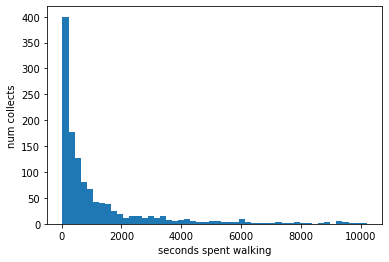

In [27]:
plt.ylabel("num collects")
plt.xlabel("seconds spent walking")
plt.hist(y_vals, bins=50)
plt.savefig('plots/seconds_spent_walking.png')

In [28]:
np.mean(y_vals) / 60

19.932344173441734

In [29]:
np.std(y_vals) / 60

29.425359673763126

In [30]:
np.median(y_vals) / 60

8.025

**x_plot**

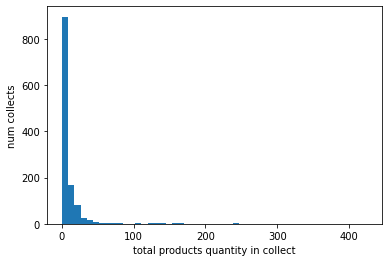

In [31]:
plt.xlabel("total products quantity in collect")
plt.ylabel("num collects")
plt.hist(x_vals, bins= 50)
plt.savefig('plots/total_products_quantity_in_collect.png')

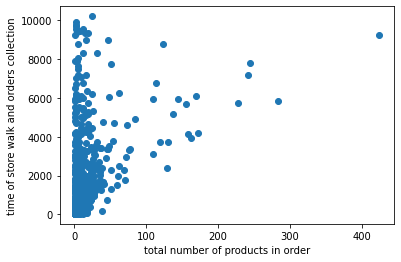

In [32]:
plt.xlabel("total number of products in order")
plt.ylabel("time of store walk and orders collection")
plt.scatter(x_vals, y_vals)
plt.savefig('plots/exp1_alldata_correlation.png')

In [33]:
np.corrcoef(x_vals, y_vals) # Pearson

array([[1.        , 0.41129742],
       [0.41129742, 1.        ]])

In [34]:
# simple

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

X = np.array([[v] for v in x_vals]).reshape(-1, 1)
reg = LinearRegression().fit(X[:int(len(y_vals) * 0.8)], np.array(y_vals[:int(len(y_vals) * 0.8)]))
reg.score(X[int(len(y_vals) * 0.8):], y_vals[int(len(y_vals) * 0.8):])

0.10955234476985842

In [35]:
# train
mae(reg.predict(X[:int(len(y_vals) * 0.8)]), y_vals[:int(len(y_vals) * 0.8)]) / 60

16.17398408208394

In [36]:
# val
mae(reg.predict(X[int(len(y_vals) * 0.8):]), y_vals[int(len(y_vals) * 0.8):]) / 60

19.50239635968031

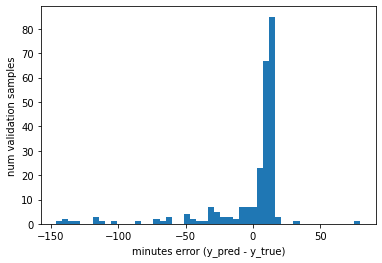

In [37]:
# errors plot
plt.ylabel("num validation samples")
plt.xlabel("minutes error (y_pred - y_true)")
plt.hist((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60, bins = 50)
plt.savefig('plots/exp1_alldata_errors_plot.png')

In [38]:
len(y_vals[int(len(y_vals) * 0.8):])

246

In [39]:
np.sum(np.abs((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 5 )

22

In [40]:
22 / 246 # 13% of validations samples were predicted with error of < 5 mins

0.08943089430894309

In [41]:
np.sum(np.abs((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 10 )

73

In [42]:
73 / 246 # 10% of validations samples were predicted with error of < 10 mins

0.2967479674796748

In [43]:
l = {"experiment_num": "1", 
 "model_type": "Lin reg no processing", 
 "train_mae": mae(reg.predict(X[:int(len(y_vals) * 0.8)]), y_vals[:int(len(y_vals) * 0.8)]) / 60, 
 "val_mae": mae(reg.predict(X[int(len(y_vals) * 0.8):]), y_vals[int(len(y_vals) * 0.8):]) / 60, 
 "perc_lt_5mins": np.sum(np.abs((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 5 ) / len(y_vals[int(len(y_vals) * 0.8):]),
 "perc_lt_10mins": np.sum(np.abs((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 10 ) / len(y_vals[int(len(y_vals) * 0.8):]),
    "train_preds": reg.predict(X[:int(len(y_vals) * 0.8)]),
    "val_preds": reg.predict(X[int(len(y_vals) * 0.8):])}

metrics_df_lst.append(l)



# Experiment 1 
# Lin reg x and y tranforms

In [44]:
def transform_y(y):
    return np.cbrt(y)

def inv_transform_y(y):
    return np.power(y,3)

def transform_products_quantity(x):
    return np.cbrt(x)

def inv_transform_products_quantity(x):
    return np.power(x,3)

### Cbrt Target distribution:

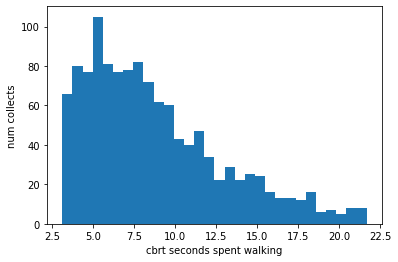

In [45]:
plt.hist(transform_y(y_vals), bins=30) # not involved

plt.ylabel("num collects")
plt.xlabel("cbrt seconds spent walking")
plt.savefig('plots/cbrt_seconds_spent_walking.png')

In [46]:
# CBRT total_products_quantity

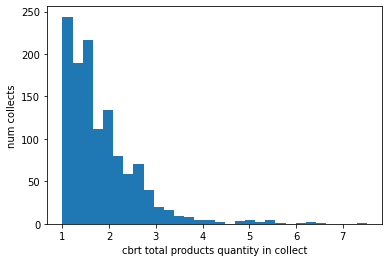

In [47]:
plt.hist(transform_products_quantity(x_vals),bins = 30)
plt.xlabel("cbrt total products quantity in collect")
plt.ylabel("num collects")
plt.savefig('plots/cbrt_total_products_quantity_in_collect.png')

In [48]:
# Cbrt Feature,cbrt  target correlation

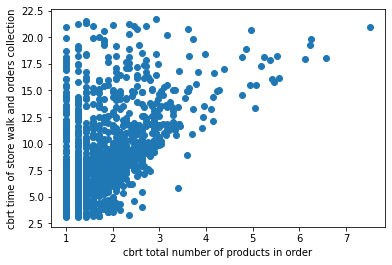

In [49]:
plt.scatter(transform_products_quantity(x_vals), transform_y(y_vals))
plt.xlabel("cbrt total number of products in order")
plt.ylabel("cbrt time of store walk and orders collection")
plt.savefig('plots/exp1_cbrt_alldata_correlation.png')

In [50]:
np.corrcoef(transform_products_quantity(x_vals), transform_y(y_vals)) 

array([[1.        , 0.51570707],
       [0.51570707, 1.        ]])

In [51]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array([[v] for v in x_vals]).reshape(-1, 1)
reg = LinearRegression().fit( transform_products_quantity(X[:int(len(y_vals) * 0.8)]), transform_y(np.array(y_vals[:int(len(y_vals) * 0.8)])))
reg.score(transform_products_quantity(X[int(len(y_vals) * 0.8):]), transform_y(y_vals[int(len(y_vals) * 0.8):]))

0.2281108857051265

In [52]:
# train mae
mae(inv_transform_y(reg.predict(transform_products_quantity(X[:int(len(y_vals) * 0.8)]))), y_vals[:int(len(y_vals) * 0.8)]) / 60

13.373244976842237

In [53]:
# val mae
mae(inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))), y_vals[int(len(y_vals) * 0.8):]) / 60

16.24237568872319

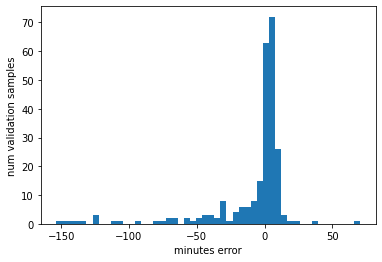

In [54]:
plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60, bins = 50)

plt.savefig('plots/exp1_linreg_cbrt_alldata_errors_plot.png')


In [55]:
np.sum(np.abs((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 5)

110

In [56]:
len(y_vals[int(len(y_vals) * 0.8):])

246

In [57]:
110 / 246 # 30% with error < 5 mins

0.44715447154471544

In [58]:
np.sum(np.abs((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 10)

172

In [59]:
172 / 246 # 54% with error < 10 mins

0.6991869918699187

In [60]:
l = {"experiment_num": "1", 
 "model_type": "Lin reg x,y cbrt", 
 "train_mae": mae(inv_transform_y(reg.predict(transform_products_quantity(X[:int(len(y_vals) * 0.8)]))), y_vals[:int(len(y_vals) * 0.8)]) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))), y_vals[int(len(y_vals) * 0.8):]) / 60, 
 "perc_lt_5mins": np.sum(np.abs((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 5) / len(y_vals[int(len(y_vals) * 0.8):]),
 "perc_lt_10mins": np.sum(np.abs((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 10) / len(y_vals[int(len(y_vals) * 0.8):]),
    "train_preds": inv_transform_y(reg.predict(transform_products_quantity(X[:int(len(y_vals) * 0.8)]))),
    "val_preds": inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):])))}

metrics_df_lst.append(l)

In [61]:
381 / 644 # 59% can be predicted with error < 10 minutes

0.5916149068322981

In [62]:
451 / 644 # 70% can be predicted with error < 15 minutes

0.7003105590062112

In [63]:
501 / 644 # 78% can be predicted with error < 20 minutes

0.7779503105590062

(array([174.,  26.,  12.,  10.,   7.,   5.,   1.,   1.,   3.,   7.]),
 array([  0.55      ,  16.65833333,  32.76666667,  48.875     ,
         64.98333333,  81.09166667,  97.2       , 113.30833333,
        129.41666667, 145.525     , 161.63333333]),
 <BarContainer object of 10 artists>)

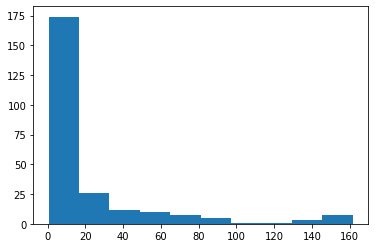

In [64]:
# dist of validation target
plt.hist(np.array(y_vals[int(len(y_vals) * 0.8):]) / 60)

In [65]:
np.mean(np.array(y_vals[int(len(y_vals) * 0.8):]) / 60)

21.328116531165314

In [66]:
np.std(np.array(y_vals[int(len(y_vals) * 0.8):]) / 60)

34.02130826555971

(array([232.,   9.,   2.,   1.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([  4.76904719,  26.79196554,  48.81488389,  70.83780224,
         92.86072058, 114.88363893, 136.90655728, 158.92947562,
        180.95239397, 202.97531232, 224.99823067]),
 <BarContainer object of 10 artists>)

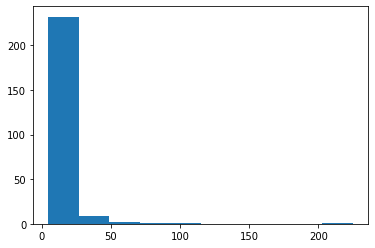

In [67]:
# dist of validation target predictions
plt.hist(inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) / 60)

# Experiment 1 
# LGBM no transforms

In [68]:
# from lightgbm import LGBMRegressor

# x_vals = list(order_collects_df.groupby("collect_id")["products_quantity"].sum())
# y_vals = list(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())

# import random
# random.seed(21)

# xy_vals = list(zip(x_vals, y_vals))
# random.Random(21).shuffle(xy_vals)

# x_vals = [x[0] for x in xy_vals]
# y_vals = [x[1] for x in xy_vals]


# import numpy as np
# from sklearn.linear_model import LinearRegression

# from sklearn.ensemble import RandomForestRegressor

# from sklearn.metrics import mean_absolute_error as mae

# X = np.array([[v] for v in x_vals]).reshape(-1, 1)

# from sklearn.model_selection import GridSearchCV
# parameters = {"n_estimators":[100,200,300],"max_bin":[50, 100, 200, 300], "learning_rate": [0.01, 0.05, 0.1, 0.3],  "min_data_in_leaf": [2, 5, 10, 30, 50],
#               "metric": ["mae"], "boosting_type":["gbdt"], "n_jobs": [-1]}
# lgbm = LGBMRegressor()
# reg = GridSearchCV(lgbm, parameters)
# reg.fit(X[:int(len(y_vals) * 0.8)], np.array(y_vals[:int(len(y_vals) * 0.8)]))


# reg.score(X[int(len(y_vals) * 0.8):], y_vals[int(len(y_vals) * 0.8):])

In [69]:
# reg.best_params_

In [70]:
#train
# mae(reg.predict(X[:int(len(y_vals) * 0.8)]), y_vals[:int(len(y_vals) * 0.8)]) / 60

In [71]:
#val
# mae(reg.predict(X[int(len(y_vals) * 0.8):]), y_vals[int(len(y_vals) * 0.8):]) / 60

# Experiment 1 
# RandForest no transforms

In [72]:
x_vals = list(order_collects_df.groupby("collect_id")["products_quantity"].sum())
y_vals = list(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())

import random
random.seed(21)

xy_vals = list(zip(x_vals, y_vals))
random.Random(21).shuffle(xy_vals)

x_vals = [x[0] for x in xy_vals]
y_vals = [x[1] for x in xy_vals]


import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae

X = np.array([[v] for v in x_vals]).reshape(-1, 1)

from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30],
              "criterion": ["absolute_error"], "max_samples":[None, 0.6, 0.8], "n_jobs":[-1]}
rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=2)
reg.fit(X[:int(len(y_vals) * 0.8)], np.array(y_vals[:int(len(y_vals) * 0.8)]))


reg.score(X[int(len(y_vals) * 0.8):], y_vals[int(len(y_vals) * 0.8):])


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END criterion=absolute_error, max_samples=None, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   1.1s
[CV] END criterion=absolute_error, max_samples=None, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.2s
[CV] END criterion=absolute_error, max_samples=None, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.2s
[CV] END criterion=absolute_error, max_samples=None, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.2s
[CV] END criterion=absolute_error, max_samples=None, min_samples_split=2, n_estimators=50, n_jobs=-1; total time=   0.2s
[CV] END criterion=absolute_error, max_samples=None, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.3s
[CV] END criterion=absolute_error, max_samples=None, min_samples_split=2, n_estimators=100, n_jobs=-1; total time=   0.3s
[CV] END criterion=absolute_error, max_samples=None, min_samples_split=2, n_estimators=10

[CV] END criterion=absolute_error, max_samples=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1; total time=   0.2s
[CV] END criterion=absolute_error, max_samples=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1; total time=   0.2s
[CV] END criterion=absolute_error, max_samples=0.6, min_samples_split=10, n_estimators=100, n_jobs=-1; total time=   0.3s
[CV] END criterion=absolute_error, max_samples=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.4s
[CV] END criterion=absolute_error, max_samples=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.4s
[CV] END criterion=absolute_error, max_samples=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.4s
[CV] END criterion=absolute_error, max_samples=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.4s
[CV] END criterion=absolute_error, max_samples=0.6, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.4s
[CV] END criterion=absol

0.04607149570419666

In [73]:
reg.best_params_

{'criterion': 'absolute_error',
 'max_samples': 0.6,
 'min_samples_split': 10,
 'n_estimators': 100,
 'n_jobs': -1}

In [74]:
#train
mae(reg.predict(X[:int(len(y_vals) * 0.8)]), y_vals[:int(len(y_vals) * 0.8)]) / 60

12.69946282181572

In [75]:
#val
mae(reg.predict(X[int(len(y_vals) * 0.8):]), y_vals[int(len(y_vals) * 0.8):]) / 60

15.893260840108404

(array([ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  2.,  1.,  0.,  1.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  3.,  0.,  2.,
         1.,  1.,  4.,  1.,  2.,  2.,  4.,  4.,  1.,  3.,  8.,  1.,  6.,
         7., 16., 46., 76., 25.,  9.,  2.,  3.,  3.,  1.,  1.]),
 array([-157.48966667, -153.73467   , -149.97967333, -146.22467667,
        -142.46968   , -138.71468333, -134.95968667, -131.20469   ,
        -127.44969333, -123.69469667, -119.9397    , -116.18470333,
        -112.42970667, -108.67471   , -104.91971333, -101.16471667,
         -97.40972   ,  -93.65472333,  -89.89972667,  -86.14473   ,
         -82.38973333,  -78.63473667,  -74.87974   ,  -71.12474333,
         -67.36974667,  -63.61475   ,  -59.85975333,  -56.10475667,
         -52.34976   ,  -48.59476333,  -44.83976667,  -41.08477   ,
         -37.32977333,  -33.57477667,  -29.81978   ,  -26.06478333,
         -22.30978667,  -18.55479   ,  -14.79979333,  -11.04479667,
          -7.2898    ,   -3.53480333

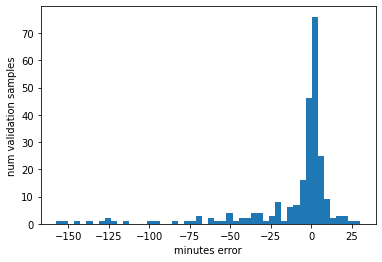

In [76]:
# errors plot
plt.ylabel("num validation samples")
plt.xlabel("minutes error")
plt.hist((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60, bins = 50)
#plt.savefig('plots/exp1_alldata_rand_for_errors_plot.png')


In [77]:
len(y_vals[int(len(y_vals) * 0.8):])

246

In [78]:
np.sum(np.abs((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 5 )

133

In [79]:
135 / 246

0.5487804878048781

In [80]:
np.sum(np.abs((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 10 )

172

In [81]:
173 / 246

0.7032520325203252

MAE = 17.4 mins

In [82]:
l = {"experiment_num": "1", 
 "model_type": "Rand forest no processing", 
 "train_mae": mae(reg.predict(X[:int(len(y_vals) * 0.8)]), y_vals[:int(len(y_vals) * 0.8)]) / 60, 
 "val_mae": mae(reg.predict(X[int(len(y_vals) * 0.8):]), y_vals[int(len(y_vals) * 0.8):]) / 60, 
 "perc_lt_5mins": np.sum(np.abs((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 5 ) / len(y_vals[int(len(y_vals) * 0.8):]),
 "perc_lt_10mins": np.sum(np.abs((reg.predict(X[int(len(y_vals) * 0.8):]) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 10 ) / len(y_vals[int(len(y_vals) * 0.8):]),
    "train_preds": reg.predict(X[:int(len(y_vals) * 0.8)]),
    "val_preds": reg.predict(X[int(len(y_vals) * 0.8):])}

metrics_df_lst.append(l)

# Experiment 1 
# RandForest cbrt x, y transforms

In [83]:
x_vals = list(order_collects_df.groupby("collect_id")["products_quantity"].sum())
y_vals = list(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())


import random
random.seed(21)

xy_vals = list(zip(x_vals, y_vals))
random.Random(21).shuffle(xy_vals)

x_vals = [x[0] for x in xy_vals]
y_vals = [x[1] for x in xy_vals]


import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae

X = np.array([[v] for v in x_vals]).reshape(-1, 1)

from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"]}
rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters)
reg.fit(transform_products_quantity(X[:int(len(y_vals) * 0.8)]), transform_y(np.array(y_vals[:int(len(y_vals) * 0.8)])))


reg.score(transform_products_quantity(X[int(len(y_vals) * 0.8):]), transform_y(y_vals[int(len(y_vals) * 0.8):]))




0.14428329404219908

In [84]:
# train mae
mae(inv_transform_y(reg.predict(transform_products_quantity(X[:int(len(y_vals) * 0.8)]))), y_vals[:int(len(y_vals) * 0.8)]) / 60

13.13471493553577

In [85]:
# val mae
mae(inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))), y_vals[int(len(y_vals) * 0.8):]) / 60

15.77508511256954

In [86]:
reg.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(),
 'n_jobs': None,
 'param_grid': {'n_estimators': [50, 100, 200],
  'min_samples_split': [2, 10, 30, 0.02, 0.05, 0.1, 0.2],
  'criterion': ['absolute_error']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

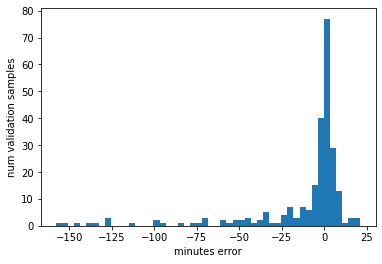

In [87]:
plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60, bins = 50)

plt.savefig('plots/exp1_alldata_cbrt_rand_for_errors_plot.png')

In [88]:
np.sum(np.abs((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 5)

137

In [89]:
136 / 246

0.5528455284552846

In [90]:
np.sum(np.abs((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 10)

178

In [91]:
179 / 246

0.7276422764227642

In [92]:
l = {"experiment_num": "1", 
 "model_type": "Rand forest cbrt y", 
 "train_mae": mae(inv_transform_y(reg.predict(transform_products_quantity(X[:int(len(y_vals) * 0.8)]))), y_vals[:int(len(y_vals) * 0.8)]) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))), y_vals[int(len(y_vals) * 0.8):]) / 60, 
 "perc_lt_5mins": np.sum(np.abs((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 5) / len(y_vals[int(len(y_vals) * 0.8):]),
 "perc_lt_10mins": np.sum(np.abs((inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):]))) - y_vals[int(len(y_vals) * 0.8):]) / 60) < 10) / len(y_vals[int(len(y_vals) * 0.8):]),
    "train_preds": inv_transform_y(reg.predict(transform_products_quantity(X[:int(len(y_vals) * 0.8)]))),
    "val_preds": inv_transform_y(reg.predict(transform_products_quantity(X[int(len(y_vals) * 0.8):])))}

metrics_df_lst.append(l)

# Experiment 2
# One-hot encode cells (without level) where products are located

In [93]:
# preparation

In [94]:
# place_lst = list([x[0]] for x in products_list_df["cleaned_place"])

# from sklearn.preprocessing import MultiLabelBinarizer

# place_binarizer = MultiLabelBinarizer()
# place_binarizer.fit(place_lst)

# place_vectors = place_binarizer.transform(place_lst)


# product_id_to_place_vect = {}

# for ind, i in enumerate(list(products_list_df['product_id'])):
#     product_id_to_place_vect[i] = place_vectors[ind]
    

# order_id_to_product_id_list = dict(order_list_df.groupby("order_id")["product_id"].apply(list))

# order_id_to_places_vect = {}

# for k in order_id_to_product_id_list.keys():
#     vect_lst = []
    
#     for p in order_id_to_product_id_list.get(k, []):
        
#         if p in product_id_to_place_vect:
#             vect_lst.append(product_id_to_place_vect[p])
        
#     if vect_lst:
#         order_id_to_places_vect[k] = sum(vect_lst)

    
    

# collect_id_to_order_id_list = dict(order_collects_df.groupby("collect_id")["order_id"].apply(list))


# collect_id_to_places_vect = {}

# for k in collect_id_to_order_id_list.keys():
#     vect_lst = []
    
#     for oid in collect_id_to_order_id_list.get(k, []):
#         if oid in order_id_to_places_vect:
#             vect_lst.append(order_id_to_places_vect[oid])
        
#     if vect_lst:
#         collect_id_to_places_vect[k] = sum(vect_lst)
#         # No values larger than 1. Only 1 for cells to which we have to walk
#         #collect_id_to_places_vect[k][collect_id_to_places_vect[k] > 0] = 1


# collect_id_to_time_spent_walking = dict(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())
        
    
# train_keys = collect_id_keys_train
# val_keys = collect_id_keys_val
        

In [23]:
products_list_df.iloc[250:260]

,product_id,sku_code,name,volume,place,warehouse_name,cleaned_place,short_cleaned_place,place_cell,place_level
6799,8684,80176,Muntons Irish Stout - Темное,0.002352,B-08-3,5,[B-8-3],[B-8-3],[B-8],[3]
6801,8686,40355K1,Сифон полуавтоматичкеский Easy 56см,NaN,A-02-1,5,[A-2-1],[A-2-1],[A-2],[1]
6810,8695,017.571.1,Бугельная пробка 10шт,NaN,B-07-4,5,[B-7-4],[B-7-4],[B-7],[4]
6812,8697,С01gold,Кроненпробка золотая 26мм (100шт),NaN,B-04-3,5,[B-4-3],[B-4-3],[B-4],[3]
6813,8698,84113,Muntons Spray Malt Extra Light (DME) - Сухой э...,0.000800,"B-06-4,B-08-3",5,"[B-6-4, B-8-3]","[B-6-4, B-8-3]","[B-6, B-8]","[4, 3]"
6819,8704,15351,Механическая мойка для пивных бутылок,NaN,02-2,5,[2-2],[2-2],[2],[2]
6820,8705,17501,Укупорщик бутылок Emily 26мм + 29мм,NaN,A-04-4,5,[A-4-4],[A-4-4],[A-4],[4]
6822,8707,40230,Mangrove Jack's Pure Malt Extract 1.2кг - LME,0.002576,A-20-4,5,[A-20-4],[A-20-4],[A-20],[4]
6823,8708,40244,Mangrove Jack's Amber Malt Extract 1.5кг - LME,0.003213,B-07-4,5,[B-7-4],[B-7-4],[B-7],[4]
6824,8709,004.005.0,Chemipro OXI - активный кислород 100 гр.,0.000142,07-4-2,5,[7-4-2],[7-4],[7],[4]


In [24]:
place_lst = list([x[0]] for x in products_list_df["place_cell"])

In [25]:
from sklearn.preprocessing import MultiLabelBinarizer

place_binarizer = MultiLabelBinarizer()
place_binarizer.fit(place_lst)

place_vectors = place_binarizer.transform(place_lst)


product_id_to_place_vect = {}

for ind, i in enumerate(list(products_list_df['product_id'])):
    product_id_to_place_vect[i] = place_vectors[ind]

In [ ]:
place_lst

In [68]:
with open('models/place_lst_clust1.npy', 'wb') as f:

    np.save(f, place_lst)

In [26]:
order_id_to_product_id_list = dict(order_list_df.groupby("order_id")["product_id"].apply(list))

order_id_to_places_vect = {}

for k in order_id_to_product_id_list.keys():
    vect_lst = []
    
    for p in order_id_to_product_id_list.get(k, []):
        
        if p in product_id_to_place_vect:
            vect_lst.append(product_id_to_place_vect[p])
        
    if vect_lst:
        order_id_to_places_vect[k] = sum(vect_lst)


In [27]:
collect_id_to_order_id_list = dict(order_collects_df.groupby("collect_id")["order_id"].apply(list))

In [28]:
collect_id_to_places_vect = {}


for k in collect_id_to_order_id_list.keys():
    vect_lst = []
    
    for oid in collect_id_to_order_id_list.get(k, []):
        if oid in order_id_to_places_vect:
            vect_lst.append(order_id_to_places_vect[oid])
        
    if vect_lst:
        collect_id_to_places_vect[k] = sum(vect_lst)
        # No values larger than 1. Only 1 for cells to which we have to walk
        #collect_id_to_places_vect[k][collect_id_to_places_vect[k] > 0] = 1

In [29]:
collect_id_to_time_spent_walking = dict(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())

In [30]:
list(collect_id_to_time_spent_walking.items())[:10]

[(2691, 491.00000000000006),
 (2704, 150.0),
 (2712, 269.0),
 (2720, 859.0),
 (2731, 1442.0),
 (2754, 722.0),
 (2755, 1206.0),
 (2758, 1944.0000000000002),
 (2764, 60.00000000000001),
 (2766, 4141.0)]

In [31]:
order_collects_df.head()

,collect_id,order_id,products_quantity,collect_date,warehouse_name,num_orders,created_at,collect_time,approx_store_walk_end,approx_store_walk_time,time_order_sorted,collect_sort_time,products_quantity_unique,products_quantity_unique_in_collect
5183,2691,174972,1,2020-12-12 16:11:00,5,7,2020-12-12 16:02:49,0 days 00:08:11,2020-12-12 16:11:00,0 days 00:08:11,0 days 00:00:00,0 days 00:00:00,1,2
5184,2691,174951,1,2020-12-12 16:11:00,5,7,2020-12-12 16:02:49,0 days 00:08:11,2020-12-12 16:11:00,0 days 00:08:11,0 days 00:00:00,0 days 00:00:00,1,2
5641,2704,175593,1,2020-12-14 14:54:00,5,2,2020-12-14 14:49:30,0 days 00:04:30,2020-12-14 14:52:00,0 days 00:02:30,0 days 00:02:00,0 days 00:02:00,1,2
5642,2704,175721,1,2020-12-14 14:52:00,5,2,2020-12-14 14:49:30,0 days 00:02:30,2020-12-14 14:52:00,0 days 00:02:30,0 days 00:00:00,0 days 00:02:00,1,2
5860,2712,175283,8,2020-12-14 17:47:00,5,1,2020-12-14 17:42:31,0 days 00:04:29,2020-12-14 17:47:00,0 days 00:04:29,0 days 00:00:00,0 days 00:00:00,8,8


In [32]:
# Try predict from vector of places 

In [33]:
train_keys = collect_id_keys_train
val_keys = collect_id_keys_val

In [34]:
# preparation end

# Experiment 2
# Linreg, no x,y processing

In [35]:
train_x = []
val_x = []
train_y = []
val_y = []

for k in train_keys:
    if (k in collect_id_to_places_vect) and (k in collect_id_to_time_spent_walking):
        train_x.append(collect_id_to_places_vect[k])
        train_y.append(collect_id_to_time_spent_walking[k])
    
for k in val_keys:
    if (k in collect_id_to_places_vect) and (k in collect_id_to_time_spent_walking):
        val_x.append(collect_id_to_places_vect[k])
        val_y.append(collect_id_to_time_spent_walking[k])


In [36]:
len(train_x[100])

156

In [37]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae


X = np.array(train_x)
reg = LinearRegression().fit(X, np.array(train_y))
reg.score(val_x, np.array(val_y))

-4.4588071325964735

In [38]:
# train
mae(reg.predict(np.array(X)), np.array(train_y)) / 60

16.47481107031867

In [39]:
# val
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60

20.87460068132845

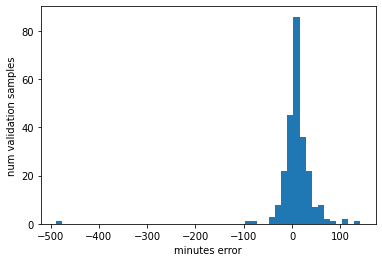

In [40]:
# errors plot

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins = 50)

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.savefig('plots/exp2_alldata_linreg_errors_plot.png')

In [41]:
np.sum(np.abs((reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)

45

In [42]:
len(val_y) 

246

In [43]:
84 / 620 # 13% can be predicted with error < 5 minutes

0.13548387096774195

In [44]:
np.sum(np.abs((reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)

87

In [45]:
212 / 620

0.3419354838709677

In [46]:
l = {"experiment_num": "2", 
 "model_type": "Lin reg no y processing", 
 "train_mae": mae(reg.predict(np.array(X)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs((reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs((reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(X)),
    "val_preds":reg.predict(np.array(val_x))}

metrics_df_lst.append(l)

# Experiment 2 
# Linreg cbrt y preprocessing

In [119]:
train_x = []
val_x = []
train_y = []
val_y = []

for k in train_keys:
    if (k in collect_id_to_places_vect) and (k in collect_id_to_time_spent_walking):
        train_x.append(collect_id_to_places_vect[k])
        train_y.append(collect_id_to_time_spent_walking[k])
    
for k in val_keys:
    if (k in collect_id_to_places_vect) and (k in collect_id_to_time_spent_walking):
        val_x.append(collect_id_to_places_vect[k])
        val_y.append(collect_id_to_time_spent_walking[k])


In [120]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae


X = np.array(train_x)
reg = LinearRegression().fit(X, transform_y(np.array(train_y)))
reg.score(val_x, transform_y(np.array(val_y)))

-1.8809787302461674

In [121]:
# train
mae( inv_transform_y(reg.predict(np.array(X))), np.array(train_y)) / 60

14.134823620672162

In [122]:
# val
mae( inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60

27.157105978233954

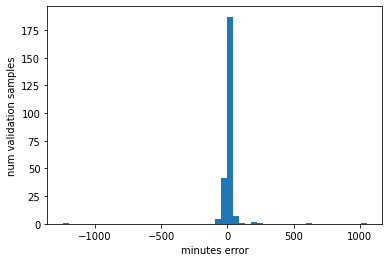

In [123]:
plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins = 50)

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.savefig('plots/exp2_alldata_cbrt_y_linreg_errors_plot.png')

In [124]:
len(val_y)

246

In [125]:
np.sum(np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)

82

In [126]:
150 / 620

0.24193548387096775

In [127]:
np.sum(np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

148

In [128]:
379 / 620

0.6112903225806452

In [129]:
# np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60).argmax()

In [130]:
# np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60)[168]

In [131]:
# np.array(val_y)[18]#

In [132]:
l = {"experiment_num": "2", 
 "model_type": "Lin cbrt y processing", 
 "train_mae": mae( inv_transform_y(reg.predict(np.array(X))), np.array(train_y)) / 60, 
 "val_mae": mae( inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x))) }

metrics_df_lst.append(l)

# Experiment 2
# Rand Forest, cbrt y processing

In [47]:
train_x = []
val_x = []
train_y = []
val_y = []

for k in train_keys:
    if (k in collect_id_to_places_vect) and (k in collect_id_to_time_spent_walking):
        train_x.append(collect_id_to_places_vect[k])
        train_y.append(collect_id_to_time_spent_walking[k])
    
for k in val_keys:
    if (k in collect_id_to_places_vect) and (k in collect_id_to_time_spent_walking):
        val_x.append(collect_id_to_places_vect[k])
        val_y.append(collect_id_to_time_spent_walking[k])

In [48]:
# val_keys[168]

In [49]:
# collect_id_to_time_spent_walking[13648]

In [50]:
def transform_y(y):
    return np.cbrt(y)

def inv_transform_y(y):
    return np.power(y,3)

def transform_products_quantity(x):
    return np.cbrt(x)

def inv_transform_products_quantity(x):
    return np.power(x,3)


In [51]:

import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), transform_y(np.array(train_y)))


reg.score(np.array(train_x), transform_y(np.array(train_y)))


Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.155 total time=   2.6s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.139 total time=   1.9s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.085 total time=   2.0s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.202 total time=   2.1s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.116 total time=   2.1s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.178 total time=   3.6s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.133 total time=   3.5s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, scor

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.241 total time=   3.7s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.226 total time=   3.8s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.198 total time=   4.0s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.118 total time=   6.5s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.173 total time=   6.6s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.255 total time=   7.0s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.249 total time=   7.1s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.218 total time=   7.7s
[CV 1/5

0.5381525368597015

In [52]:
reg.best_params_

{'criterion': 'absolute_error',
 'min_samples_split': 30,
 'n_estimators': 100,
 'n_jobs': -1}

In [53]:
# train
mae( inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60

12.856467905241564

In [54]:
# val
mae( inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60

9.966244435821588

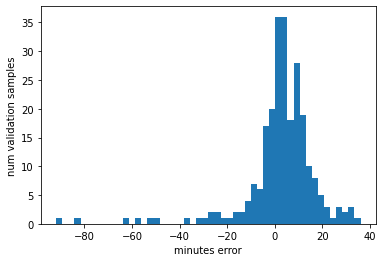

In [55]:
# errors plot

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins = 50)

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.savefig('plots/exp2_alldata_cbrt_rand_for_errors_plot.png')

In [56]:
np.sum(np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)

106

In [57]:
len(val_y)

246

In [58]:
215 / 620

0.3467741935483871

In [73]:
np.sum(np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

168

In [146]:
369 / 620

0.5951612903225807

In [60]:
l = {"experiment_num": "2", 
 "model_type": "Rand forest cbrt y processing", 
 "train_mae": mae( inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae( inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x))) }

metrics_df_lst.append(l)

In [62]:
with open('models/val_x_clust1.npy', 'wb') as f:

    np.save(f, val_x)

In [63]:
with open('models/val_y_clust1.npy', 'wb') as f:

    np.save(f, val_y)

In [64]:
with open('models/val_keys_clust1.npy', 'wb') as f:
    np.save(f, val_keys)

In [65]:
import pickle

with open("models/clust_1_exp2_alldata_cbrt_rand_for_model.pkl", "wb") as f:
    pickle.dump(reg.best_estimator_, f)

In [149]:

import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae

import pickle

reg = None
with open("models/exp2_alldata_cbrt_rand_for_model.pkl", "rb") as f:
    reg = pickle.load(f)


In [69]:
reg_model = reg.best_estimator_

In [78]:
type(reg_model)

sklearn.ensemble._forest.RandomForestRegressor

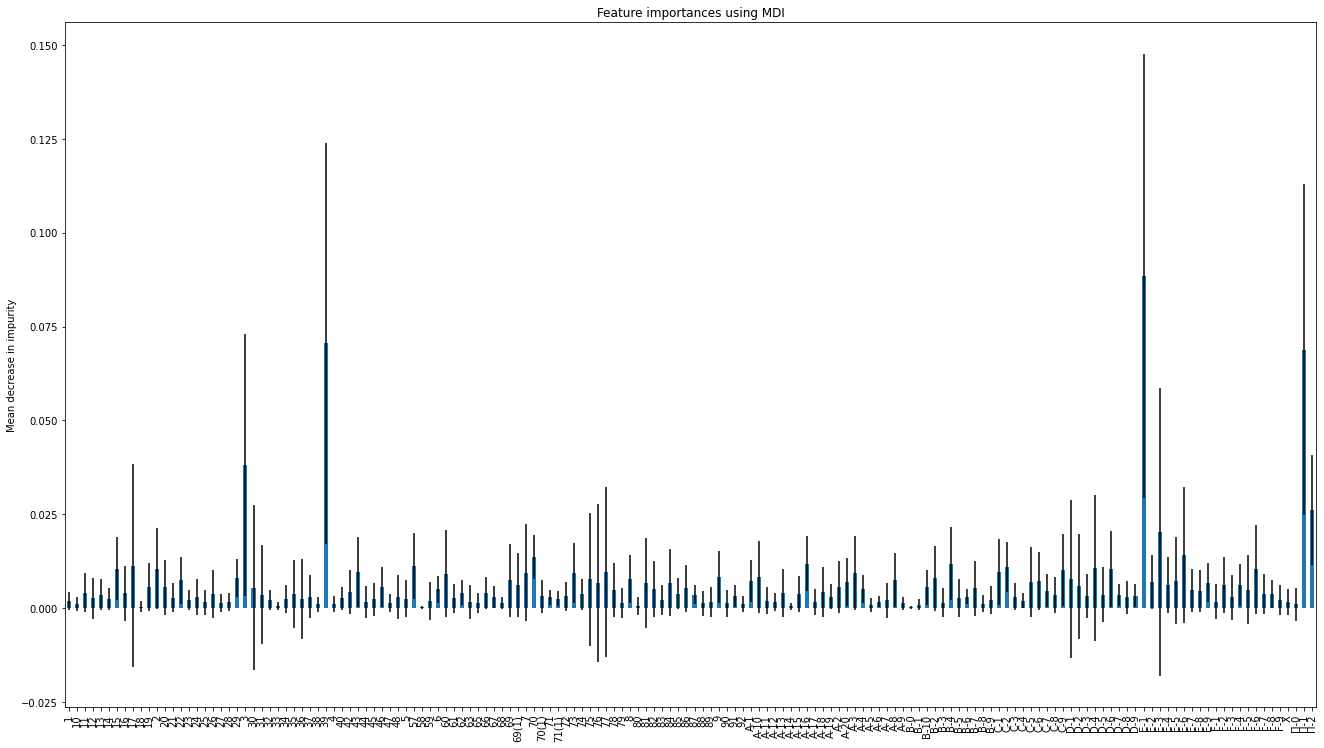

In [71]:
import matplotlib.pyplot as plt
import pandas as pd

forest_importances = pd.Series(reg_model.feature_importances_, index=list(place_binarizer.classes_))
std = np.std([tree.feature_importances_ for tree in reg_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.set_size_inches(37 / 2, 21 / 2)
fig.tight_layout()

In [153]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(
    reg_model, np.array(val_x), transform_y(np.array(val_y)), n_repeats=30, random_state=42, n_jobs=-1
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=list(place_binarizer.classes_))

Elapsed time to compute the importances: 32.187 seconds


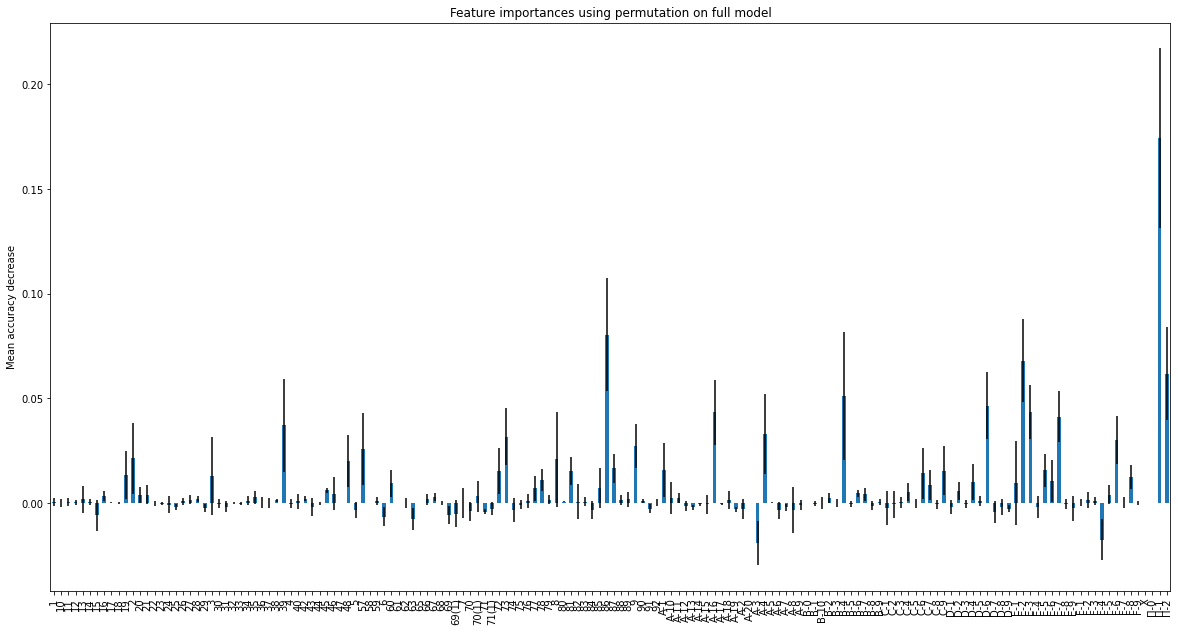

In [154]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
fig.set_size_inches(37 / 2, 21 / 2)
plt.show()

In [74]:
import shap 

explainer = shap.TreeExplainer(reg.best_estimator_, check_additivity=False)

shap_values = explainer(np.array(train_x), check_additivity=False)

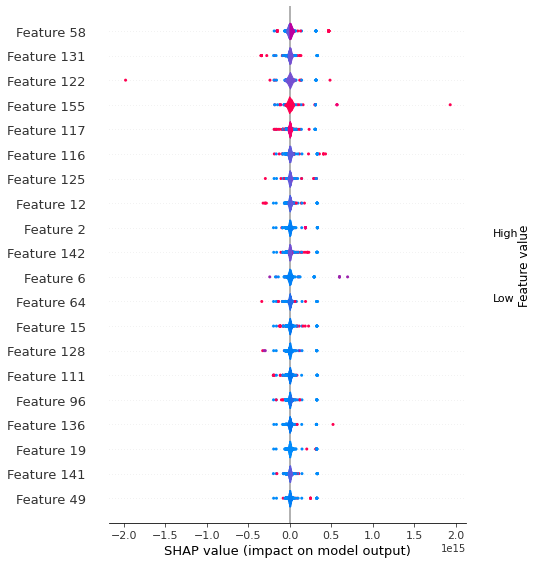

In [75]:
shap.summary_plot(shap_values, plot_type='violin')

In [77]:
with open('models/mean_shap_values_clust1.npy', 'wb') as f:

    np.save(f, shap_values.values.mean(axis=0))

In [76]:
shap_values.values.mean(axis=0)

array([ 1.28436482e+12,  1.00511021e+12,  3.48599656e+12,  4.01052033e+11,
        1.32914895e+12,  1.91887954e+12,  4.87389133e+12,  1.80200815e+12,
        1.07974645e+12,  1.21343074e+12,  1.51542821e+12,  1.93739019e+12,
        1.29560442e+12,  2.80982388e+12,  1.90521092e+12,  1.96062341e+12,
        1.76079800e+11,  5.81993219e+10,  2.56755713e+12,  2.85306078e+12,
        1.96966189e+12,  1.35488959e+12,  1.90905569e+12,  7.95139007e+11,
       -2.68728309e+10,  1.23897019e+12,  6.87827543e+10,  1.12743203e+12,
        1.83587839e+12,  8.81068157e+11,  1.74665660e+12,  7.05556498e+10,
        1.56288927e+12,  1.55000642e+12,  1.98087742e+11,  1.79608206e+12,
        1.60286097e+12,  9.39619389e+10,  2.29752418e+12,  2.43701975e+12,
        1.83402028e+12,  7.58795157e+09,  1.21975518e+12,  1.44046838e+12,
       -1.62004691e+09, -7.87615062e+09,  1.57588086e+12,  7.53120425e+11,
        1.96214948e+11,  3.01969360e+12,  1.02291642e+10,  1.15699900e+12,
        1.40219528e+12,  

In [72]:
np.argmin(np.sum(train_x, axis=0))

105

In [156]:
np.sum(train_x, axis=0)[75]

92

In [157]:
np.argmax(place_binarizer.classes_ == '84')

75

In [158]:
place_binarizer.classes_[75]

'84'

In [159]:
bool_lst = []
for x in products_list_df["place_cell"]:
    if '84' in x:
        bool_lst.append(True)
    else:
        bool_lst.append(False)

In [160]:
sum(bool_lst)

124

In [161]:
from collections import Counter
c = Counter()
for x in products_list_df["place_cell"]:
    c.update(x)

In [162]:
c.most_common()

[('75', 247),
 ('70', 238),
 ('C-2', 221),
 ('32', 194),
 ('36', 183),
 ('22', 180),
 ('87', 174),
 ('38', 172),
 ('79', 166),
 ('74', 163),
 ('4', 152),
 ('12', 149),
 ('35', 146),
 ('76', 145),
 ('39', 144),
 ('C-1', 144),
 ('86', 141),
 ('30', 141),
 ('29', 140),
 ('43', 131),
 ('31', 125),
 ('78', 125),
 ('84', 124),
 ('92', 120),
 ('60', 116),
 ('16', 115),
 ('33', 114),
 ('C-6', 114),
 ('88', 109),
 ('C-7', 104),
 ('C-8', 104),
 ('28', 103),
 ('69', 100),
 ('7', 99),
 ('15', 99),
 ('34', 98),
 ('42', 98),
 ('45', 97),
 ('14', 94),
 ('C-5', 94),
 ('D-3', 94),
 ('77', 91),
 ('40', 90),
 ('D-8', 89),
 ('91', 89),
 ('85', 85),
 ('C-3', 84),
 ('10', 83),
 ('80', 83),
 ('17', 80),
 ('11', 79),
 ('68', 78),
 ('81', 77),
 ('20', 76),
 ('69(1)', 76),
 ('D-4', 75),
 ('46', 75),
 ('3', 75),
 ('2', 74),
 ('21', 71),
 ('D-5', 69),
 ('5', 68),
 ('6', 67),
 ('63', 67),
 ('B-5', 66),
 ('44', 65),
 ('D-2', 64),
 ('B-6', 64),
 ('13', 64),
 ('62', 63),
 ('B-10', 63),
 ('B-9', 63),
 ('E-5', 62),
 ('

In [163]:
products_list_df[bool_lst].iloc[:20]

,product_id,sku_code,name,volume,place,warehouse_name,cleaned_place,short_cleaned_place,place_cell,place_level
7156,9048,L049,Чаша бамбуковая с лопаткой,0.000100,84-2,5A,[84-2],[84-2],[84],[2]
7393,43764,id_3676.1,3676.черный.М,NaN,84-3,5A,[84-3],[84-3],[84],[3]
9265,11087,228100XM,Дозатор (диспенсер) сенсорный для жидкого мыла...,0.004458,84-3,5,[84-3],[84-3],[84],[3]
9425,11242,10853G,шапки,NaN,84-2,5,[84-2],[84-2],[84],[2]
9429,11246,10921A,шапки,NaN,84-1,5,[84-1],[84-1],[84],[1]
9503,11317,10175E,балаклава,NaN,84-5-1,5,[84-5-1],[84-5],[84],[5]
9518,11333,10928A,шапки,NaN,84-4,5,[84-4],[84-4],[84],[4]
9895,11704,NS-11-7,Кусачки для кожи SMART 11 7 мм,NaN,84-4,5,[84-4],[84-4],[84],[4]
9896,11705,NS-20-5,Кусачки для кожи SMART 20 5 мм,NaN,84-4,5,[84-4],[84-4],[84],[4]
9897,11706,NS-20-7,Кусачки для кожи SMART 20 7 мм,NaN,84-4,5,[84-4],[84-4],[84],[4]


In [164]:
products_list_df.head()

,product_id,sku_code,name,volume,place,warehouse_name,cleaned_place,short_cleaned_place,place_cell,place_level
151,616,10830,262,NaN,21-2,5,[21-2],[21-2],[21],[2]
159,624,1898,1065,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
160,625,2748,1065,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
164,629,2747,1460,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
184,649,2019,1063,NaN,22-2-1,5,[22-2-1],[22-2],[22],[2]


## Experiment 2
## Random forest no y processing

In [165]:

import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), np.array(train_y))


reg.score(np.array(train_x), np.array(train_y))




Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.100 total time=   2.2s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.048 total time=   2.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.125 total time=   2.6s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.027 total time=   2.5s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.041 total time=   2.6s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.111 total time=   4.1s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.030 total time=   4.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, s

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.127 total time=   4.6s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.047 total time=   4.8s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.061 total time=   4.9s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.115 total time=   8.2s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.103 total time=   8.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.165 total time=   9.0s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.058 total time=   9.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.077 total time=   9.8s
[CV 1/5

0.5105787996405022

In [166]:
# reg.best_params_

# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60



12.299165311653116

In [167]:
#val
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60


12.504330623306231

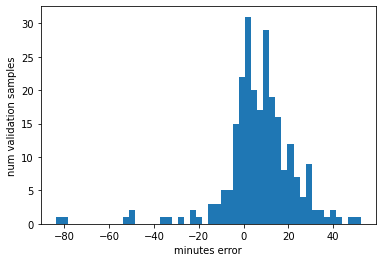

In [168]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp4_alldata_rand_for_errors_plot.png')



In [169]:

np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)



82

In [170]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)



125

In [171]:

len(val_y)


246

In [172]:
l = {"experiment_num": "2", 
 "model_type": "Rand forest no y processing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x)) }

metrics_df_lst.append(l)

In [173]:
# 

# Experiment 3
# Number of cells on different level as a feature

In [174]:
level_lst = [[str(x) for x in l] for l in list(products_list_df["place_level"])]

In [175]:
from sklearn.preprocessing import MultiLabelBinarizer

level_binarizer = MultiLabelBinarizer()
level_binarizer.fit(level_lst)

level_vectors = level_binarizer.transform(level_lst)


product_id_to_level_vect = {}

for ind, i in enumerate(list(products_list_df['product_id'])):
    product_id_to_level_vect[i] = level_vectors[ind]

In [176]:
order_id_to_product_id_list = dict(order_list_df.groupby("order_id")["product_id"].apply(list))

order_id_to_level_vect = {}

for k in order_id_to_product_id_list.keys():
    vect_lst = []
    
    for p in order_id_to_product_id_list.get(k, []):
        
        if p in product_id_to_level_vect:
            vect_lst.append(product_id_to_level_vect[p])
        
    if vect_lst:
        order_id_to_level_vect[k] = sum(vect_lst)


In [177]:
collect_id_to_order_id_list = dict(order_collects_df.groupby("collect_id")["order_id"].apply(list))

In [178]:
collect_id_to_levels_vect = {}


for k in collect_id_to_order_id_list.keys():
    vect_lst = []
    
    for oid in collect_id_to_order_id_list.get(k, []):
        if oid in order_id_to_level_vect:
            vect_lst.append(order_id_to_level_vect[oid])
        
    if vect_lst:
        collect_id_to_levels_vect[k] = sum(vect_lst)
#         # No values larger than 1. Only 1 for cells to which we have to walk
#         collect_id_to_places_vect[k][collect_id_to_places_vect[k] > 0] = 1

In [179]:
collect_id_to_time_spent_walking = dict(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())

In [180]:
train_x = []
val_x = []
train_y = []
val_y = []

for k in train_keys:
    if (k in collect_id_to_levels_vect) and (k in collect_id_to_time_spent_walking):
        train_x.append(collect_id_to_levels_vect[k])
        train_y.append(collect_id_to_time_spent_walking[k])
    
for k in val_keys:
    if (k in collect_id_to_levels_vect) and (k in collect_id_to_time_spent_walking):
        val_x.append(collect_id_to_levels_vect[k])
        val_y.append(collect_id_to_time_spent_walking[k])

In [79]:
2 * 2 * 2 * 3 * 6 + 2

146

# Experiment 3
# Linreg no preprocessing

In [181]:
#HEREEEEE
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_absolute_error as mae

# from sklearn.ensemble import RandomForestRegressor

# X = np.array(train_x)
# reg = LinearRegression().fit(X, np.array(train_y))
# reg.score(np.array(val_x), np.array(val_y))

# # train
# mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60

# mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60

# # errors plot

# plt.ylabel("num validation samples")
# plt.xlabel("minutes error")

# plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


# plt.savefig('plots/exp3_alldata_linreg_errors_plot.png')

# np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)

# np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)



In [182]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array(train_x)
reg = LinearRegression().fit(X, np.array(train_y))
reg.score(np.array(val_x), np.array(val_y))

-0.32113797629939556

In [183]:
# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60

18.756273403053353

In [184]:
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60

14.091264434901026

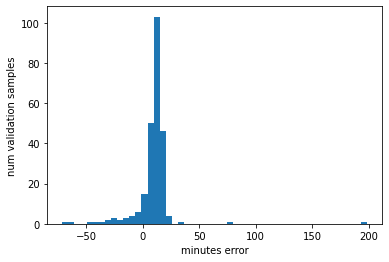

In [185]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp3_alldata_linreg_errors_plot.png')

In [186]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)

23

In [187]:
60 / 620

0.0967741935483871

In [188]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)

78

In [189]:
134 / 620

0.2161290322580645

In [190]:
len(val_y)

246

In [191]:
l = {"experiment_num": "3", 
 "model_type": "Linreg no preprocessing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x))}

metrics_df_lst.append(l)

# Experiment 3
# Linreg cbrt y preprocessing

In [192]:
#HEREEEEE
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_absolute_error as mae

# from sklearn.ensemble import RandomForestRegressor

# X = np.array(train_x)
# reg = LinearRegression().fit(X, transform_y(np.array(train_y)))
# reg.score(np.array(val_x), transform_y(np.array(val_y)))

# # train
# mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60

# #val
# mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60

# # errors plot

# plt.ylabel("num validation samples")
# plt.xlabel("minutes error")

# plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


# plt.savefig('plots/exp4_alldata_linreg_cbrt_errors_plot.png')

# np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)

# np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

In [193]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array(train_x)
reg = LinearRegression().fit(X, transform_y(np.array(train_y)))
reg.score(np.array(val_x), transform_y(np.array(val_y)))

-0.1644101186698561

In [194]:
# train
mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60

16.516092639546674

In [195]:
#val
mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60

17.069026351498295

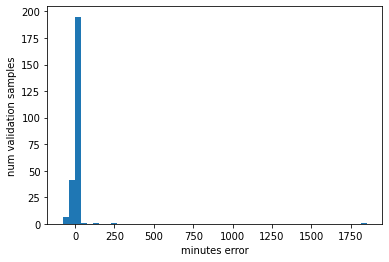

In [196]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp3_alldata_linreg_cbrt_errors_plot.png')

In [197]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)

95

In [198]:
182 / 620

0.29354838709677417

In [199]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

206

In [200]:
401 / 620

0.646774193548387

In [201]:
len(val_y)

246

In [202]:
l = {"experiment_num": "3", 
 "model_type": "Linreg cbrt y preprocessing", 
 "train_mae": mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x))) }

metrics_df_lst.append(l)

# Experiment 3
# Rand Forest no preprocessing

In [203]:
#HEREEEEE
# import numpy as np
# from sklearn.linear_model import LinearRegression

# from sklearn.ensemble import RandomForestRegressor

# from sklearn.metrics import mean_absolute_error as mae


# from sklearn.model_selection import GridSearchCV
# parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
#               "criterion": ["absolute_error"], "n_jobs":[-1]}

# rand_for = RandomForestRegressor()
# reg = GridSearchCV(rand_for, parameters, verbose=3)
# reg.fit(np.array(train_x), np.array(train_y))


# reg.score(np.array(train_x), np.array(train_y))




# # reg.best_params_

# # train
# mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60

# #val
# mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60


# # errors plot

# plt.ylabel("num validation samples")
# plt.xlabel("minutes error")

# plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


# plt.savefig('plots/exp4_alldata_rand_for_errors_plot.png')


# np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)


# np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)


# len(val_y)


In [204]:
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), np.array(train_y))


reg.score(np.array(train_x), np.array(train_y))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.092 total time=   0.2s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.058 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.058 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.041 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.234 total time=   0.2s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.113 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.053 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, sc

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.276 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.034 total time=   0.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.204 total time=   0.3s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.135 total time=   0.4s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.136 total time=   0.4s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.274 total time=   0.4s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.042 total time=   0.4s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.206 total time=   0.4s
[CV 1/5

0.20611499652562904

In [205]:
reg.best_params_

{'criterion': 'absolute_error',
 'min_samples_split': 30,
 'n_estimators': 50,
 'n_jobs': -1}

In [206]:
# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60

14.121965955284553

In [207]:
#val
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60

8.163651761517615

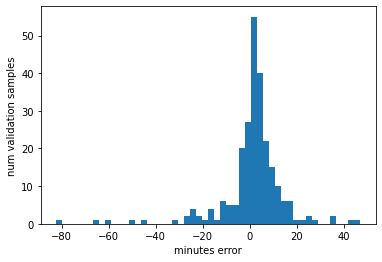

In [208]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp3_alldata_rand_for_errors_plot.png')

In [209]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)

139

In [210]:
len(val_y)

246

In [211]:
247 / 620

0.39838709677419354

In [212]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)

188

In [213]:
399 / 620

0.6435483870967742

In [214]:
l = {"experiment_num": "3", 
 "model_type": "Rand forest no preprocessing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x)) }

metrics_df_lst.append(l)

# Experiment 3
# Rand Forest cbrt y preprocessing

In [215]:
#HEREEEEE
# import numpy as np
# from sklearn.linear_model import LinearRegression

# from sklearn.ensemble import RandomForestRegressor

# from sklearn.metrics import mean_absolute_error as mae


# from sklearn.model_selection import GridSearchCV
# parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
#               "criterion": ["absolute_error"], "n_jobs":[-1]}

# rand_for = RandomForestRegressor()
# reg = GridSearchCV(rand_for, parameters, verbose=3)
# reg.fit(np.array(train_x), transform_y(np.array(train_y)))


# reg.score(np.array(train_x), transform_y(np.array(train_y)))

# reg.best_params_

# # train
# mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60

# #val
# mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60

# # errors plot

# plt.ylabel("num validation samples")
# plt.xlabel("minutes error")

# plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


# plt.savefig('plots/exp4_alldata_rand_for_cbrt_errors_plot.png')

# np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)

# len(val_y)

# np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)


In [216]:
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), transform_y(np.array(train_y)))


reg.score(np.array(train_x), transform_y(np.array(train_y)))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.146 total time=   0.2s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.148 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.208 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.171 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.077 total time=   0.2s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.144 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.124 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, scor

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.373 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.182 total time=   0.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.307 total time=   0.3s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.146 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.149 total time=   0.4s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.378 total time=   0.4s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.196 total time=   0.4s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.310 total time=   0.3s
[CV 1/5

0.2653527521833121

In [217]:
reg.best_params_

{'criterion': 'absolute_error',
 'min_samples_split': 0.05,
 'n_estimators': 200,
 'n_jobs': -1}

In [218]:
# train
mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60

14.619181710053391

In [219]:
mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60

7.523400114663111

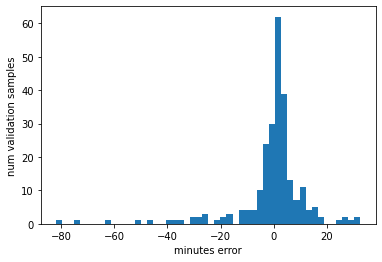

In [220]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp3_alldata_rand_for_cbrt_errors_plot.png')

In [221]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)

160

In [222]:
len(val_y)

246

In [223]:
272 / 620

0.43870967741935485

In [224]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

195

In [225]:
407 / 620

0.6564516129032258

In [226]:
l = {"experiment_num": "3", 
 "model_type": "Rand forest cbrt y preprocessing", 
 "train_mae": mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y) ,
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x)))}

metrics_df_lst.append(l)

## Experiment 4
## LINE WHERE PRODUCTS ARE PLACED AS FEATURE

In [227]:
# {0: [1-16], 1: [17-32], 2: [33-49], 3: [57-72], 4: [(1) and [73-80]], 5: [81-92], 
#  6:[A], 7:[B], 8:[C], 9:[D], 10: [E], 11:[F], 12:[П] 12:[X] }

In [228]:
def place_cell_to_line_vector(place_cell):
    num_lines = 13
    vect = np.zeros(13)
    
    range_to_line_ind = {(1,17): 0, (17,33): 1, (33,50): 2, (57,73): 3, 
                         (73,81): 4, (81,93): 5}
    letter_to_line_ind = {"(1)": 4, "A": 6, "B": 7, "C": 8, "D": 9, "E": 10, "F": 11, "П": 12, "X": 12}
    
    for c in place_cell:
        if c.isnumeric():
            cnum = int(c)
            for r in range_to_line_ind.keys():
                if cnum in list(range(*r)):
                    vect[range_to_line_ind[r]] += 1
        else:
            for l in letter_to_line_ind.keys():
                if l in c:
                    vect[letter_to_line_ind[l]] += 1
                    
    return vect
            

In [229]:
products_list_df.head()

,product_id,sku_code,name,volume,place,warehouse_name,cleaned_place,short_cleaned_place,place_cell,place_level
151,616,10830,262,NaN,21-2,5,[21-2],[21-2],[21],[2]
159,624,1898,1065,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
160,625,2748,1065,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
164,629,2747,1460,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
184,649,2019,1063,NaN,22-2-1,5,[22-2-1],[22-2],[22],[2]


In [230]:
list(range(1,16))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [231]:
"12(1)".isnumeric()

False

In [232]:
range(*(1, 17))

range(1, 17)

In [233]:
place_cell_to_line_vector(["21(1)"])

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [234]:
product_id_to_line_vect = {}

for ind, row in products_list_df.iterrows():
    product_id_to_line_vect[row["product_id"]] = place_cell_to_line_vector(row["place_cell"])

In [235]:
order_id_to_product_id_list = dict(order_list_df.groupby("order_id")["product_id"].apply(list))

order_id_to_line_vect = {}

for k in order_id_to_product_id_list.keys():
    vect_lst = []
    
    for p in order_id_to_product_id_list.get(k, []):
        
        if p in product_id_to_line_vect:
            vect_lst.append(product_id_to_line_vect[p])
        
    if vect_lst:
        order_id_to_line_vect[k] = sum(vect_lst)

In [236]:
collect_id_to_order_id_list = dict(order_collects_df.groupby("collect_id")["order_id"].apply(list))

In [237]:
collect_id_to_line_vect = {}


for k in collect_id_to_order_id_list.keys():
    vect_lst = []
    
    for oid in collect_id_to_order_id_list.get(k, []):
        if oid in order_id_to_line_vect:
            vect_lst.append(order_id_to_line_vect[oid])
        
    if vect_lst:
        collect_id_to_line_vect[k] = sum(vect_lst)
        # No values larger than 1. Only 1 for cells to which we have to walk
        # collect_id_to_line_vect[k][collect_id_to_line_vect[k] > 0] = 1

In [238]:
collect_id_to_time_spent_walking = dict(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())

In [239]:
train_keys = collect_id_keys_train
val_keys = collect_id_keys_val

train_x = []
val_x = []
train_y = []
val_y = []

for k in train_keys:
    if (k in collect_id_to_line_vect) and (k in collect_id_to_time_spent_walking):
        train_x.append(collect_id_to_line_vect[k])
        train_y.append(collect_id_to_time_spent_walking[k])
    
for k in val_keys:
    if (k in collect_id_to_line_vect) and (k in collect_id_to_time_spent_walking):
        val_x.append(collect_id_to_line_vect[k])
        val_y.append(collect_id_to_time_spent_walking[k])

## Experiment 4
## Lin reg no x, y processing

In [240]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array(train_x)
reg = LinearRegression().fit(X, np.array(train_y))
reg.score(np.array(val_x), np.array(val_y))



0.019082630758016084

In [241]:
# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60


18.633110786621113

In [242]:
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60


14.285322163631559

In [243]:
# errors plot

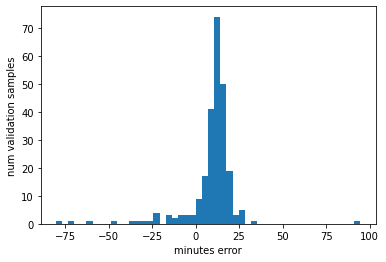

In [244]:
plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp4_alldata_linreg_errors_plot.png')



In [245]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)


16

In [246]:
len(val_y)

246

In [247]:
67 / 620

0.10806451612903226

In [248]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)

66

In [249]:
150 / 620

0.24193548387096775

In [250]:
l = {"experiment_num": "4", 
 "model_type": "Lin reg no preprocessing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x)) }

metrics_df_lst.append(l)

## Experiment 4
## Lin reg cbrt y processing

In [251]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array(train_x)
reg = LinearRegression().fit(X, transform_y(np.array(train_y)))
reg.score(np.array(val_x), transform_y(np.array(val_y)))


0.16562522679590053

In [252]:
# train
mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60



16.230685640164868

In [253]:
#val
mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60


10.713355989930673

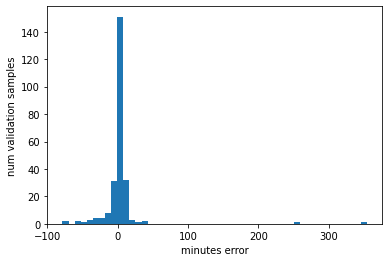

In [254]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp4_alldata_linreg_cbrt_errors_plot.png')


In [255]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)


96

In [256]:
159 / 620

0.2564516129032258

In [257]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

205

In [258]:
378 / 620

0.6096774193548387

In [259]:
len(val_y)

246

In [260]:
l = {"experiment_num": "4", 
 "model_type": "Lin reg cbrt y preprocessing", 
 "train_mae": mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x))) }

metrics_df_lst.append(l)

## Experiment 4
## Rand forest no x,y processing

In [261]:
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), np.array(train_y))


reg.score(np.array(train_x), np.array(train_y))


Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.055 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.094 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.073 total time=   0.3s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.027 total time=   0.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.188 total time=   0.3s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.059 total time=   0.4s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.060 total time=   0.4s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, 

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.277 total time=   0.4s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.072 total time=   0.4s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.191 total time=   0.4s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.103 total time=   0.6s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.050 total time=   0.6s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.282 total time=   0.6s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.057 total time=   0.6s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.166 total time=   0.6s
[CV 1/5

0.30598891242174486

In [262]:
reg.best_params_


{'criterion': 'absolute_error',
 'min_samples_split': 30,
 'n_estimators': 200,
 'n_jobs': -1}

In [263]:
# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60


13.613232215447153

In [264]:
#val
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60


9.570707994579946

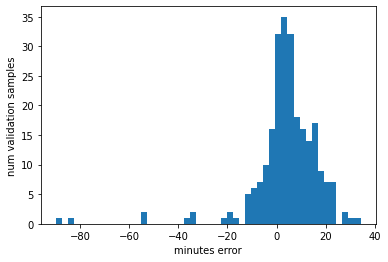

In [265]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp4_alldata_rand_for_errors_plot.png')



In [266]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)


101

In [267]:
98 / 246

0.3983739837398374

In [268]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)


158

In [269]:
333 / 620

0.5370967741935484

In [270]:

len(val_y)

246

In [271]:
l = {"experiment_num": "4", 
 "model_type": "Rand forest no preprocessing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x)) }

metrics_df_lst.append(l)

## Experiment 4
## Rand forest y cbrt processing

In [272]:
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), transform_y(np.array(train_y)))


reg.score(np.array(train_x), transform_y(np.array(train_y)))



Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.089 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.058 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.262 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.193 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.100 total time=   0.3s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.075 total time=   0.4s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.112 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, scor

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.384 total time=   0.3s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.224 total time=   0.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.281 total time=   0.3s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.065 total time=   0.5s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.159 total time=   0.5s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.386 total time=   0.5s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.227 total time=   0.5s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.284 total time=   0.5s
[CV 1/5

0.39887327370323

In [273]:
reg.best_params_



{'criterion': 'absolute_error',
 'min_samples_split': 30,
 'n_estimators': 100,
 'n_jobs': -1}

In [274]:
# train
mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60



13.67297130212804

In [275]:
#val
mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60



8.006149002083712

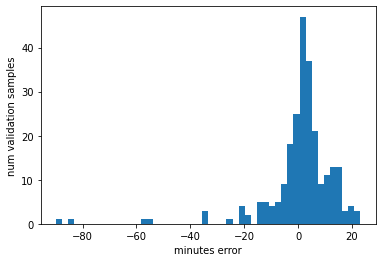

In [276]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp4_alldata_rand_for_cbrt_errors_plot.png')



In [277]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)



134

In [278]:
251 / 620

0.40483870967741936

In [279]:
len(val_y)


246

In [280]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

177

In [281]:
396 / 620

0.6387096774193548

In [282]:
l = {"experiment_num": "4", 
 "model_type": "Rand forest cbrt y preprocessing", 
 "train_mae": mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x))) }

metrics_df_lst.append(l)

## Experiment 5
## Num of cells with many products in same place as feature

Note: cells have to consider sub-cells if given

In [283]:
# note: place not shortened
from collections import Counter
place_to_num_products = Counter()

for p in list(products_list_df["cleaned_place"]):
    place_to_num_products.update(p)

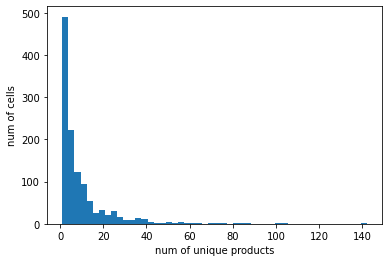

In [284]:
# number of cell with num of unique products

plt.ylabel("num of cells")
plt.xlabel("num of unique products")
plt.hist(list(place_to_num_products.values()), bins=50)


plt.savefig('plots/num_cell_with_num_unique_prods.png')


In [285]:
sum(np.array(list(place_to_num_products.values())) < 5)

574

In [286]:
sum((np.array(list(place_to_num_products.values())) >= 5) & (np.array(list(place_to_num_products.values())) <= 15))

411

In [287]:
sum((np.array(list(place_to_num_products.values())) > 15) & (np.array(list(place_to_num_products.values())) <= 30))

129

In [288]:
sum((np.array(list(place_to_num_products.values())) >= 30))

83

In [289]:
prod_id_to_place_dict = {}

for ind, row in products_list_df.iterrows():
    prod_id_to_place_dict[row["product_id"]] = row["cleaned_place"]

In [290]:
def place_to_many_prods_cluster_vect(place):
    p = place[0]
    num_clusts = 4
    num_prods = place_to_num_products[p]
    vect = np.zeros(num_clusts)
    if num_prods < 5:
        vect[0] = 1
    elif (num_prods >= 5) and (num_prods <= 15):
        vect[1] = 1
    elif (num_prods > 15) and (num_prods <= 30):
        vect[2] = 1
    else:
        vect[3] = 1
    return vect
        
    
order_id_to_product_id_list = dict(order_list_df.groupby("order_id")["product_id"].apply(list))

order_id_to_many_prods_cluster_vect = {}

for k in order_id_to_product_id_list.keys():
    vect_lst = []
    
    for p in order_id_to_product_id_list.get(k, []):
        
        if p in prod_id_to_place_dict:
            vect_lst.append(place_to_many_prods_cluster_vect(prod_id_to_place_dict[p]))
        
    if vect_lst:
        order_id_to_many_prods_cluster_vect[k] = sum(vect_lst)

In [291]:
collect_id_to_order_id_list = dict(order_collects_df.groupby("collect_id")["order_id"].apply(list))

collect_id_to_many_prods_cluster_vect = {}


for k in collect_id_to_order_id_list.keys():
    vect_lst = []
    
    for oid in collect_id_to_order_id_list.get(k, []):
        if oid in order_id_to_many_prods_cluster_vect:
            vect_lst.append(order_id_to_many_prods_cluster_vect[oid])
        
    if vect_lst:
        collect_id_to_many_prods_cluster_vect[k] = sum(vect_lst)
        # No values larger than 1. Only 1 for cells to which we have to walk
        # collect_id_to_line_vect[k][collect_id_to_line_vect[k] > 0] = 1

In [292]:
list(collect_id_to_many_prods_cluster_vect.items())[:3]

[(2691, array([2., 0., 0., 0.])),
 (2704, array([0., 1., 0., 1.])),
 (2712, array([3., 2., 2., 1.]))]

In [293]:
collect_id_to_time_spent_walking = dict(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())

In [294]:
train_keys = collect_id_keys_train
val_keys = collect_id_keys_val

train_x = []
val_x = []
train_y = []
val_y = []

for k in train_keys:
    if (k in collect_id_to_many_prods_cluster_vect) and (k in collect_id_to_time_spent_walking):
        train_x.append(collect_id_to_many_prods_cluster_vect[k])
        train_y.append(collect_id_to_time_spent_walking[k])
    
for k in val_keys:
    if (k in collect_id_to_many_prods_cluster_vect) and (k in collect_id_to_time_spent_walking):
        val_x.append(collect_id_to_many_prods_cluster_vect[k])
        val_y.append(collect_id_to_time_spent_walking[k])

In [295]:
train_x[:3]

[array([2., 0., 0., 0.]), array([0., 1., 0., 1.]), array([3., 2., 2., 1.])]

## Experiment 5
## Linreg no x, y processing

In [296]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array(train_x)
reg = LinearRegression().fit(X, np.array(train_y))
reg.score(np.array(val_x), np.array(val_y))



-0.027890593321980406

In [297]:
# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60



18.657231173165574

In [298]:
#val
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60


14.175998783385333

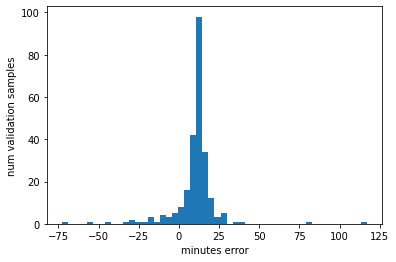

In [299]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp5_alldata_linreg_errors_plot.png')



In [300]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)


18

In [301]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)


64

In [302]:
len(val_y)

246

In [303]:
69 / 620

0.11129032258064517

In [304]:
166 / 620

0.267741935483871

In [305]:
l = {"experiment_num": "5", 
 "model_type": "Lin reg no preprocessing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x)) }

metrics_df_lst.append(l)

## Experiment 5
## Linreg cbrt  y processing

In [306]:

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array(train_x)
reg = LinearRegression().fit(X, transform_y(np.array(train_y)))
reg.score(np.array(val_x), transform_y(np.array(val_y)))



0.08135111419667607

In [307]:
# train
mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60


16.244102377401244

In [308]:

#val
mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60



13.291957232274434

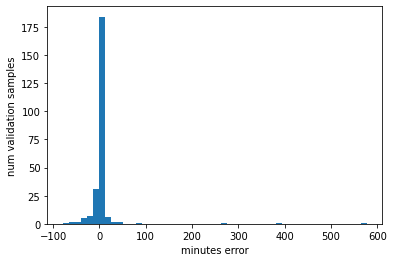

In [309]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp5_alldata_linreg_cbrt_errors_plot.png')



In [310]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)


90

In [311]:
len(val_y)

246

In [312]:
201 / 620

0.3241935483870968

In [313]:

np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

206

In [314]:
441 / 620

0.7112903225806452

In [315]:
l = {"experiment_num": "5", 
 "model_type": "Lin reg cbrt y preprocessing", 
 "train_mae": mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x))) }

metrics_df_lst.append(l)

## Experiment 5
## Rand forest no processing

In [316]:
#HEREEEEE
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), np.array(train_y))


reg.score(np.array(train_x), np.array(train_y))


Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.050 total time=   0.2s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.044 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.138 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.084 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.008 total time=   0.2s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.057 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.009 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, sc

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.271 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.038 total time=   0.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.191 total time=   0.2s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.112 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.131 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.276 total time=   0.4s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.038 total time=   0.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.189 total time=   0.5s
[CV 1/5

0.17990553112320096

In [317]:
reg.best_params_



{'criterion': 'absolute_error',
 'min_samples_split': 30,
 'n_estimators': 200,
 'n_jobs': -1}

In [318]:
# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60


14.307147315379405

In [319]:
#val
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60


8.138392784552847

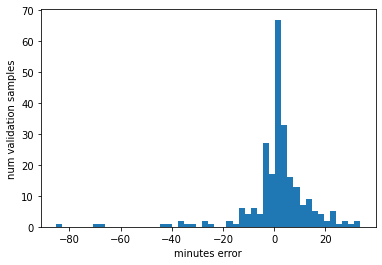

In [320]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp5_alldata_rand_for_errors_plot.png')




In [321]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)


142

In [322]:
258 / 620

0.4161290322580645

In [323]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)


187

In [324]:
402 / 620

0.6483870967741936

In [325]:
len(val_y)


246

In [326]:
l = {"experiment_num": "5", 
 "model_type": "Rand forest no preprocessing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x)) }

metrics_df_lst.append(l)

## Experiment 5
## Rand forest cbrt y processing

In [327]:

import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), transform_y(np.array(train_y)))


reg.score(np.array(train_x), transform_y(np.array(train_y)))




Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.081 total time=   0.2s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.053 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.269 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.149 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.127 total time=   0.2s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.085 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.008 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, scor

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.381 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.242 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.299 total time=   0.3s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.115 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.150 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.385 total time=   0.4s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.235 total time=   0.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.300 total time=   0.3s
[CV 1/5

0.2528593249732951

In [328]:
reg.best_params_



{'criterion': 'absolute_error',
 'min_samples_split': 0.05,
 'n_estimators': 100,
 'n_jobs': -1}

In [329]:
# train
mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60



14.675458120382281

In [330]:
#val
mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60



7.727729198942632

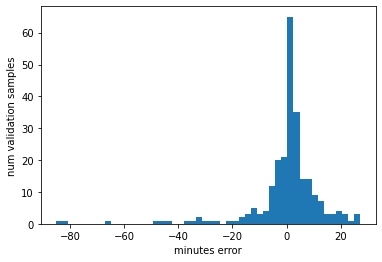

In [331]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp5_alldata_rand_for_cbrt_errors_plot.png')



In [332]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)



152

In [333]:
len(val_y)


246

In [334]:

np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

191

In [335]:
285 / 620

0.4596774193548387

In [336]:
425 / 620

0.6854838709677419

In [337]:
l = {"experiment_num": "5", 
 "model_type": "Rand forest cbrt y preprocessing", 
 "train_mae": mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x))) }

metrics_df_lst.append(l)

## Experiment 6
## Num of cells by class (with/without subcell/ pallet/ refrigerator) (cell type clustering)


In [338]:
products_list_df.head()

,product_id,sku_code,name,volume,place,warehouse_name,cleaned_place,short_cleaned_place,place_cell,place_level
151,616,10830,262,NaN,21-2,5,[21-2],[21-2],[21],[2]
159,624,1898,1065,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
160,625,2748,1065,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
164,629,2747,1460,NaN,22-3-2,5,[22-3-2],[22-3],[22],[3]
184,649,2019,1063,NaN,22-2-1,5,[22-2-1],[22-2],[22],[2]


In [339]:
all_places= set()
for p in products_list_df["cleaned_place"]:
    all_places.update(p)


In [340]:
prod_id_to_place_dict = {}

for ind, row in products_list_df.iterrows():
    prod_id_to_place_dict[row["product_id"]] = row["cleaned_place"]
    
    
def place_to_place_type_vect(place):
    # 0 - no sub cell, no pallet, no fridge
    # 1 - fridge
    # 2 - pallet
    # sub-cell
    
    p = place[0]
    num_clusts = 4
    vect = np.zeros(num_clusts)
    if "П" in p:
        vect[2] = 1
    elif "X" in p:
        vect[1] = 1
    elif ((p[0].isalpha()) and (p.count('-') >= 3)) or ((not p[0].isalpha()) and (p.count('-') >= 2)):
        vect[3] = 1
    else:
        vect[0] = 1
    
    return vect
        
    
order_id_to_product_id_list = dict(order_list_df.groupby("order_id")["product_id"].apply(list))

order_id_to_places_type_vect = {}

for k in order_id_to_product_id_list.keys():
    vect_lst = []
    
    for p in order_id_to_product_id_list.get(k, []):
        
        if p in prod_id_to_place_dict:
            vect_lst.append(place_to_place_type_vect(prod_id_to_place_dict[p]))
        
    if vect_lst:
        order_id_to_places_type_vect[k] = sum(vect_lst)
        
        
collect_id_to_order_id_list = dict(order_collects_df.groupby("collect_id")["order_id"].apply(list))

collect_id_to_places_type_vect = {}


for k in collect_id_to_order_id_list.keys():
    vect_lst = []
    
    for oid in collect_id_to_order_id_list.get(k, []):
        if oid in order_id_to_places_type_vect:
            vect_lst.append(order_id_to_places_type_vect[oid])
        
    if vect_lst:
        collect_id_to_places_type_vect[k] = sum(vect_lst)
        # No values larger than 1. Only 1 for cells to which we have to walk
        # collect_id_to_line_vect[k][collect_id_to_line_vect[k] > 0] = 1
        
        
        
collect_id_to_time_spent_walking = dict(order_collects_df.groupby("collect_id")["approx_store_walk_time"].mean().dt.total_seconds())


train_keys = collect_id_keys_train
val_keys = collect_id_keys_val

train_x = []
val_x = []
train_y = []
val_y = []

for k in train_keys:
    if (k in collect_id_to_places_type_vect) and (k in collect_id_to_time_spent_walking):
        train_x.append(collect_id_to_places_type_vect[k])
        train_y.append(collect_id_to_time_spent_walking[k])
    
for k in val_keys:
    if (k in collect_id_to_places_type_vect) and (k in collect_id_to_time_spent_walking):
        val_x.append(collect_id_to_places_type_vect[k])
        val_y.append(collect_id_to_time_spent_walking[k])

In [341]:
10757

10757

In [342]:
#val_keys[172]

In [343]:
#collect_id_to_time_spent_walking[14387]#10757

In [344]:
train_x[:3]

[array([0., 0., 0., 2.]), array([2., 0., 0., 0.]), array([5., 0., 0., 3.])]

## Experiment 6
## Lin reg no processing


In [345]:
#HEREEEEE
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array(train_x)
reg = LinearRegression().fit(X, np.array(train_y))
reg.score(np.array(val_x), np.array(val_y))



0.18418079403803356

In [346]:
# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60



18.925837364765762

In [347]:
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60



13.708512316839961

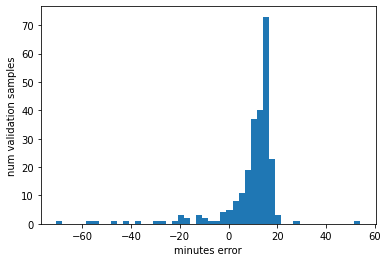

In [348]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp6_alldata_linreg_errors_plot.png')



In [349]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)



21

In [350]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)



59

In [351]:
len(val_y)

246

In [352]:
64 / 620

0.1032258064516129

In [353]:
155 / 620

0.25

In [354]:
l = {"experiment_num": "6", 
 "model_type": "Lin reg no preprocessing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x)) }

metrics_df_lst.append(l)

## Experiment 6
## Lin reg cbrt y processing

In [355]:

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae

from sklearn.ensemble import RandomForestRegressor

X = np.array(train_x)
reg = LinearRegression().fit(X, transform_y(np.array(train_y)))
reg.score(np.array(val_x), transform_y(np.array(val_y)))



0.27630427983175443

In [356]:
# train
mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60


16.957415485736487

In [357]:
#val
mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60


8.49370944475537

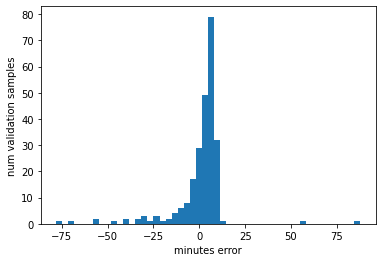

In [358]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp6_alldata_linreg_cbrt_errors_plot.png')



In [359]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)


94

In [360]:
179 / 620

0.2887096774193548

In [361]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)

216

In [362]:
379 / 620

0.6112903225806452

In [363]:
len(val_y)

246

In [365]:
l = {"experiment_num": "6", 
 "model_type": "Lin reg cbrt y preprocessing", 
 "train_mae": mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x))) }

metrics_df_lst.append(l)

## Experiment 6
## Rand forest no x,y processing


In [366]:
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), np.array(train_y))


reg.score(np.array(train_x), np.array(train_y))



Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.172 total time=   0.2s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.015 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.016 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.006 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.028 total time=   0.2s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.133 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.024 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;,

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.214 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=-0.005 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.230 total time=   0.3s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.135 total time=   0.4s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.065 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.220 total time=   0.4s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.002 total time=   0.4s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.234 total time=   0.4s
[CV 1/

0.11755133560401554

In [367]:
reg.best_params_


{'criterion': 'absolute_error',
 'min_samples_split': 0.05,
 'n_estimators': 200,
 'n_jobs': -1}

In [368]:
# train
mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60


14.787874703590784

In [369]:
#val
mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60


7.386527777777777

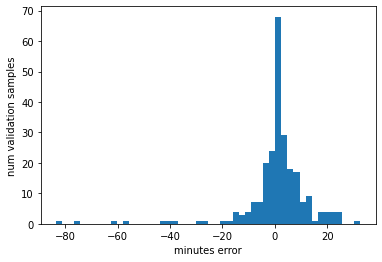

In [370]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((reg.predict(np.array(val_x)) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp6_alldata_rand_for_errors_plot.png')



In [371]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)



149

In [372]:
np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10)


194

In [373]:
len(val_y)


246

In [374]:
273 / 620

0.4403225806451613

In [375]:
412 / 620

0.6645161290322581

In [376]:
l = {"experiment_num": "6", 
 "model_type": "Rand forest no preprocessing", 
 "train_mae": mae(reg.predict(np.array(train_x)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(val_x)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(val_x)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(train_x)),
    "val_preds":reg.predict(np.array(val_x)) }

metrics_df_lst.append(l)

## Experiment 6
## Rand forest cbrt y processing

In [377]:

import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3)
reg.fit(np.array(train_x), transform_y(np.array(train_y)))


reg.score(np.array(train_x), transform_y(np.array(train_y)))



Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=-0.151 total time=   0.2s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.008 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.218 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.096 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.119 total time=   0.2s
[CV 1/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=-0.187 total time=   0.3s
[CV 2/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.022 total time=   0.2s
[CV 3/5] END criterion=absolute_error, min_samples_split=2, n_estimators=100, n_jobs=-1;, scor

[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.339 total time=   0.2s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.135 total time=   0.2s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.295 total time=   0.2s
[CV 1/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=-0.126 total time=   0.4s
[CV 2/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.069 total time=   0.3s
[CV 3/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.343 total time=   0.3s
[CV 4/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.141 total time=   0.3s
[CV 5/5] END criterion=absolute_error, min_samples_split=0.05, n_estimators=200, n_jobs=-1;, score=0.293 total time=   0.4s
[CV 1/5

0.2132123621035691

In [378]:
reg.best_params_


{'criterion': 'absolute_error',
 'min_samples_split': 0.1,
 'n_estimators': 100,
 'n_jobs': -1}

In [379]:
# train
mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60


15.104524282856874

In [380]:
#val
mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60


7.255050588992718

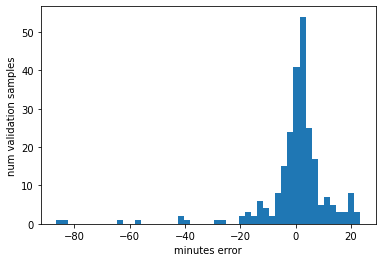

In [381]:
# errors plot

plt.ylabel("num validation samples")
plt.xlabel("minutes error")

plt.hist((inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60, bins=50)


plt.savefig('plots/exp6_alldata_rand_for_cbrt_errors_plot.png')



In [382]:
np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5)



151

In [383]:
#np.array(val_y)[172]

In [384]:
len(val_y)


246

In [385]:

np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10)


192

In [386]:
289 / 620

0.4661290322580645

In [387]:
420 / 620

0.6774193548387096

In [388]:
l = {"experiment_num": "6", 
 "model_type": "Rand forest cbrt y preprocessing", 
 "train_mae": mae(inv_transform_y(reg.predict(np.array(train_x))), np.array(train_y)) / 60, 
 "val_mae": mae(inv_transform_y(reg.predict(np.array(val_x))), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 5) / len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (inv_transform_y(reg.predict(np.array(val_x))) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": inv_transform_y(reg.predict(np.array(train_x))),
    "val_preds":inv_transform_y(reg.predict(np.array(val_x)))}

metrics_df_lst.append(l)

In [389]:
metrics_df = pd.DataFrame(metrics_df_lst)

In [390]:
metrics_df.head()

,experiment_num,model_type,train_mae,val_mae,perc_lt_5mins,perc_lt_10mins,train_preds,val_preds
0,1,Lin reg no processing,16.173984,19.502396,0.089431,0.296748,"[1245.6556340930852, 934.4598241217524, 1339.0...","[872.2206621274859, 872.2206621274859, 903.340..."
1,1,"Lin reg x,y cbrt",13.373245,16.242376,0.447154,0.699187,"[1049.698462329049, 467.12209997282974, 1193.9...","[286.1428316450367, 286.1428316450367, 385.342..."
2,1,Rand forest no processing,12.699463,15.893261,0.540650,0.699187,"[855.59, 248.62, 1729.545, 2006.825, 253.4, 15...","[155.705, 155.705, 253.4, 253.4, 2309.21, 253...."
3,1,Rand forest cbrt y,13.134715,15.775085,0.556911,0.723577,"[844.3447922266546, 236.68503166234686, 1063.5...","[157.59040104194253, 157.59040104194253, 242.8..."
4,2,Lin reg no y processing,16.474811,20.874601,0.182927,0.353659,"[1668.7458394108166, 1070.3110841108855, 1745....","[514.5099140038483, 1028.617392353253, 1261.69..."


In [391]:
metrics_df.to_csv("clust1_metrics.csv")

In [392]:
metrics_df

,experiment_num,model_type,train_mae,val_mae,perc_lt_5mins,perc_lt_10mins,train_preds,val_preds
0,1,Lin reg no processing,16.173984,19.502396,0.089431,0.296748,"[1245.6556340930852, 934.4598241217524, 1339.0...","[872.2206621274859, 872.2206621274859, 903.340..."
1,1,"Lin reg x,y cbrt",13.373245,16.242376,0.447154,0.699187,"[1049.698462329049, 467.12209997282974, 1193.9...","[286.1428316450367, 286.1428316450367, 385.342..."
2,1,Rand forest no processing,12.699463,15.893261,0.540650,0.699187,"[855.59, 248.62, 1729.545, 2006.825, 253.4, 15...","[155.705, 155.705, 253.4, 253.4, 2309.21, 253...."
3,1,Rand forest cbrt y,13.134715,15.775085,0.556911,0.723577,"[844.3447922266546, 236.68503166234686, 1063.5...","[157.59040104194253, 157.59040104194253, 242.8..."
4,2,Lin reg no y processing,16.474811,20.874601,0.182927,0.353659,"[1668.7458394108166, 1070.3110841108855, 1745....","[514.5099140038483, 1028.617392353253, 1261.69..."
5,2,Lin cbrt y processing,14.134824,27.157106,0.333333,0.601626,"[629.6094763866956, 392.366360557768, 703.6809...","[296.61766085467434, 922.7319699060707, 822.31..."
6,2,Rand forest cbrt y processing,12.336492,9.915234,0.426829,0.642276,"[344.3591256359609, 427.42477951362935, 445.82...","[200.62855900879788, 1091.8324427615007, 1046...."
7,2,Rand forest no y processing,12.299165,12.504331,0.333333,0.508130,"[371.815, 618.725, 1305.155, 1158.5, 2542.16, ...","[207.475, 1101.64, 1078.505, 1142.33, 1290.35,..."
8,3,Linreg no preprocessing,18.756273,14.091264,0.093496,0.317073,"[889.2828720610919, 872.0094603666342, 1484.24...","[919.5994142485422, 1451.9904649941036, 1213.7..."
9,3,Linreg cbrt y preprocessing,16.516093,17.069026,0.386179,0.837398,"[456.4055055268812, 471.3869104987127, 756.759...","[510.3113739768439, 906.3299610813195, 751.165..."


In [393]:
metrics_df.head()

,experiment_num,model_type,train_mae,val_mae,perc_lt_5mins,perc_lt_10mins,train_preds,val_preds
0,1,Lin reg no processing,16.173984,19.502396,0.089431,0.296748,"[1245.6556340930852, 934.4598241217524, 1339.0...","[872.2206621274859, 872.2206621274859, 903.340..."
1,1,"Lin reg x,y cbrt",13.373245,16.242376,0.447154,0.699187,"[1049.698462329049, 467.12209997282974, 1193.9...","[286.1428316450367, 286.1428316450367, 385.342..."
2,1,Rand forest no processing,12.699463,15.893261,0.540650,0.699187,"[855.59, 248.62, 1729.545, 2006.825, 253.4, 15...","[155.705, 155.705, 253.4, 253.4, 2309.21, 253...."
3,1,Rand forest cbrt y,13.134715,15.775085,0.556911,0.723577,"[844.3447922266546, 236.68503166234686, 1063.5...","[157.59040104194253, 157.59040104194253, 242.8..."
4,2,Lin reg no y processing,16.474811,20.874601,0.182927,0.353659,"[1668.7458394108166, 1070.3110841108855, 1745....","[514.5099140038483, 1028.617392353253, 1261.69..."


In [394]:
metrics_df.to_pickle("clust1_metrics.pkl")

# ENSAMBLING

Use linear regression with L1 for feature selection

In [395]:
import pandas as pd
metrics_df = pd.read_pickle("clust1_metrics.pkl")

In [396]:
import numpy as np

In [397]:
large_feature_train = np.array([list(x) for x in metrics_df["train_preds"]]).T
large_feature_val = np.array([list(x) for x in metrics_df["val_preds"]]).T

In [398]:
large_feature_train[:3]

array([[1245.65563409, 1049.69846233,  855.59      ,  844.34479223,
        1668.74583941,  629.60947639,  344.35912564,  371.815     ,
         889.28287206,  456.40550553,  213.61      ,  239.60726437,
        1010.99210497,  533.10642589,  695.7925    ,  601.76762441,
         984.67694309,  516.94787217,  608.085     ,  600.96917116,
         975.90680027,  528.99524343,  287.2625    ,  264.36568072],
       [ 934.45982412,  467.12209997,  248.62      ,  236.68503166,
        1070.31108411,  392.36636056,  427.42477951,  618.725     ,
         872.00946037,  471.3869105 ,  317.84      ,  269.33913079,
         945.74881427,  507.45831526,  432.11      ,  358.77798267,
         908.93797027,  481.52944258,  152.715     ,  159.05771345,
        1018.19071736,  575.79271942,  252.0525    ,  253.13038769],
       [1339.01437708, 1193.90983732, 1729.545     , 1063.56246803,
        1745.47998178,  703.68090569,  445.82490758, 1305.155     ,
        1484.24351246,  756.75948641,  762.8  

In [399]:
#val_y

In [400]:
#train_y

In [401]:

all_feature_combs = []
import itertools

for n in [2,3,4]:
    all_feature_combs += list(itertools.combinations(list(range(len(large_feature_train[0]))),n))



In [402]:
all_feature_combs[-1]

(20, 21, 22, 23)

In [403]:
len(large_feature_train[0])

24

In [404]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from tqdm import tqdm

# model_type 	train_mae 	val_mae 	perc_lt_5mins 	perc_lt_10mins 	train_preds 	val_preds

best_comb = []
best_val_mae = 100
best_train_mae = 100
best_perc_lt_5mins = 0
perc_lt_10mins = 0
train_preds = []
val_preds = []


for comb in tqdm(all_feature_combs):
    large_feature_train_comb = large_feature_train.T[sorted(list(comb))].T
    large_feature_val_comb = large_feature_val.T[sorted(list(comb))].T
    reg = LinearRegression().fit(np.array(large_feature_train_comb), np.array(train_y))
    
    cur_mae = mae(reg.predict(np.array(large_feature_val_comb)), np.array(val_y)) / 60
    
    if cur_mae < best_val_mae:
        best_val_mae = cur_mae
        best_comb = comb
        best_train_mae = mae(reg.predict(np.array(large_feature_train_comb)), np.array(train_y)) / 60
        best_perc_lt_5mins = np.sum(np.abs( (reg.predict(np.array(large_feature_val_comb)) - np.array(val_y)) / 60) < 5) / len(val_y)
        best_perc_lt_10mins = np.sum(np.abs( (reg.predict(np.array(large_feature_val_comb)) - np.array(val_y)) / 60) < 10) / len(val_y)
        train_preds = reg.predict(np.array(large_feature_train_comb))
        val_preds = reg.predict(np.array(large_feature_val_comb))
        

l = {"experiment_num": "10", 
 "model_type": "Lin reg ensambling features: " + str(best_comb), 
 "train_mae": best_train_mae, 
 "val_mae": best_val_mae, 
 "perc_lt_5mins": best_perc_lt_5mins ,
 "perc_lt_10mins": best_perc_lt_10mins,
    "train_preds": train_preds,
    "val_preds":val_preds}

metrics_df = metrics_df.append(l, ignore_index=True)
        
        
    
    

100%|███████████████████████████████████| 12926/12926 [00:05<00:00, 2221.54it/s]


In [405]:
metrics_df

,experiment_num,model_type,train_mae,val_mae,perc_lt_5mins,perc_lt_10mins,train_preds,val_preds
0,1,Lin reg no processing,16.173984,19.502396,0.089431,0.296748,"[1245.6556340930852, 934.4598241217524, 1339.0...","[872.2206621274859, 872.2206621274859, 903.340..."
1,1,"Lin reg x,y cbrt",13.373245,16.242376,0.447154,0.699187,"[1049.698462329049, 467.12209997282974, 1193.9...","[286.1428316450367, 286.1428316450367, 385.342..."
2,1,Rand forest no processing,12.699463,15.893261,0.540650,0.699187,"[855.59, 248.62, 1729.545, 2006.825, 253.4, 15...","[155.705, 155.705, 253.4, 253.4, 2309.21, 253...."
3,1,Rand forest cbrt y,13.134715,15.775085,0.556911,0.723577,"[844.3447922266546, 236.68503166234686, 1063.5...","[157.59040104194253, 157.59040104194253, 242.8..."
4,2,Lin reg no y processing,16.474811,20.874601,0.182927,0.353659,"[1668.7458394108166, 1070.3110841108855, 1745....","[514.5099140038483, 1028.617392353253, 1261.69..."
5,2,Lin cbrt y processing,14.134824,27.157106,0.333333,0.601626,"[629.6094763866956, 392.366360557768, 703.6809...","[296.61766085467434, 922.7319699060707, 822.31..."
6,2,Rand forest cbrt y processing,12.336492,9.915234,0.426829,0.642276,"[344.3591256359609, 427.42477951362935, 445.82...","[200.62855900879788, 1091.8324427615007, 1046...."
7,2,Rand forest no y processing,12.299165,12.504331,0.333333,0.508130,"[371.815, 618.725, 1305.155, 1158.5, 2542.16, ...","[207.475, 1101.64, 1078.505, 1142.33, 1290.35,..."
8,3,Linreg no preprocessing,18.756273,14.091264,0.093496,0.317073,"[889.2828720610919, 872.0094603666342, 1484.24...","[919.5994142485422, 1451.9904649941036, 1213.7..."
9,3,Linreg cbrt y preprocessing,16.516093,17.069026,0.386179,0.837398,"[456.4055055268812, 471.3869104987127, 756.759...","[510.3113739768439, 906.3299610813195, 751.165..."


In [406]:
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error as mae


from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[50, 100, 200], 'min_samples_split':[2, 10, 30, 0.02, 0.05, 0.1, 0.2],
              "criterion": ["absolute_error"], "n_jobs":[-1], "max_features":[0.4]}

rand_for = RandomForestRegressor()
reg = GridSearchCV(rand_for, parameters, verbose=3, cv=5)
reg.fit(np.array(large_feature_train), np.array(train_y))

reg.score(np.array(large_feature_train), np.array(train_y))

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END criterion=absolute_error, max_features=0.4, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.507 total time=   0.3s
[CV 2/5] END criterion=absolute_error, max_features=0.4, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.574 total time=   0.2s
[CV 3/5] END criterion=absolute_error, max_features=0.4, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.658 total time=   0.2s
[CV 4/5] END criterion=absolute_error, max_features=0.4, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.527 total time=   0.2s
[CV 5/5] END criterion=absolute_error, max_features=0.4, min_samples_split=2, n_estimators=50, n_jobs=-1;, score=0.596 total time=   0.3s
[CV 1/5] END criterion=absolute_error, max_features=0.4, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.508 total time=   0.3s
[CV 2/5] END criterion=absolute_error, max_features=0.4, min_samples_split=2, n_estimators=100, n_jobs=-1;, s

[CV 5/5] END criterion=absolute_error, max_features=0.4, min_samples_split=0.02, n_estimators=200, n_jobs=-1;, score=0.618 total time=   0.5s
[CV 1/5] END criterion=absolute_error, max_features=0.4, min_samples_split=0.05, n_estimators=50, n_jobs=-1;, score=0.417 total time=   0.2s
[CV 2/5] END criterion=absolute_error, max_features=0.4, min_samples_split=0.05, n_estimators=50, n_jobs=-1;, score=0.635 total time=   0.2s
[CV 3/5] END criterion=absolute_error, max_features=0.4, min_samples_split=0.05, n_estimators=50, n_jobs=-1;, score=0.680 total time=   0.2s
[CV 4/5] END criterion=absolute_error, max_features=0.4, min_samples_split=0.05, n_estimators=50, n_jobs=-1;, score=0.501 total time=   0.2s
[CV 5/5] END criterion=absolute_error, max_features=0.4, min_samples_split=0.05, n_estimators=50, n_jobs=-1;, score=0.613 total time=   0.2s
[CV 1/5] END criterion=absolute_error, max_features=0.4, min_samples_split=0.05, n_estimators=100, n_jobs=-1;, score=0.420 total time=   0.3s
[CV 2/5] EN

0.8533268780259937

In [407]:
reg.best_params_

{'criterion': 'absolute_error',
 'max_features': 0.4,
 'min_samples_split': 10,
 'n_estimators': 100,
 'n_jobs': -1}

In [408]:
l = {"experiment_num": "11", 
 "model_type": "Rand forest ensambling", 
 "train_mae": mae(reg.predict(np.array(large_feature_train)), np.array(train_y)) / 60, 
 "val_mae": mae(reg.predict(np.array(large_feature_val)), np.array(val_y)) / 60, 
 "perc_lt_5mins": np.sum(np.abs( (reg.predict(np.array(large_feature_val)) - np.array(val_y)) / 60) < 5)/ len(val_y) ,
 "perc_lt_10mins": np.sum(np.abs( (reg.predict(np.array(large_feature_val)) - np.array(val_y)) / 60) < 10) / len(val_y),
    "train_preds": reg.predict(np.array(large_feature_train)),
    "val_preds":reg.predict(np.array(large_feature_val)) }

metrics_df = metrics_df.append(l, ignore_index=True)

In [409]:
metrics_df

,experiment_num,model_type,train_mae,val_mae,perc_lt_5mins,perc_lt_10mins,train_preds,val_preds
0,1,Lin reg no processing,16.173984,19.502396,0.089431,0.296748,"[1245.6556340930852, 934.4598241217524, 1339.0...","[872.2206621274859, 872.2206621274859, 903.340..."
1,1,"Lin reg x,y cbrt",13.373245,16.242376,0.447154,0.699187,"[1049.698462329049, 467.12209997282974, 1193.9...","[286.1428316450367, 286.1428316450367, 385.342..."
2,1,Rand forest no processing,12.699463,15.893261,0.540650,0.699187,"[855.59, 248.62, 1729.545, 2006.825, 253.4, 15...","[155.705, 155.705, 253.4, 253.4, 2309.21, 253...."
3,1,Rand forest cbrt y,13.134715,15.775085,0.556911,0.723577,"[844.3447922266546, 236.68503166234686, 1063.5...","[157.59040104194253, 157.59040104194253, 242.8..."
4,2,Lin reg no y processing,16.474811,20.874601,0.182927,0.353659,"[1668.7458394108166, 1070.3110841108855, 1745....","[514.5099140038483, 1028.617392353253, 1261.69..."
5,2,Lin cbrt y processing,14.134824,27.157106,0.333333,0.601626,"[629.6094763866956, 392.366360557768, 703.6809...","[296.61766085467434, 922.7319699060707, 822.31..."
6,2,Rand forest cbrt y processing,12.336492,9.915234,0.426829,0.642276,"[344.3591256359609, 427.42477951362935, 445.82...","[200.62855900879788, 1091.8324427615007, 1046...."
7,2,Rand forest no y processing,12.299165,12.504331,0.333333,0.508130,"[371.815, 618.725, 1305.155, 1158.5, 2542.16, ...","[207.475, 1101.64, 1078.505, 1142.33, 1290.35,..."
8,3,Linreg no preprocessing,18.756273,14.091264,0.093496,0.317073,"[889.2828720610919, 872.0094603666342, 1484.24...","[919.5994142485422, 1451.9904649941036, 1213.7..."
9,3,Linreg cbrt y preprocessing,16.516093,17.069026,0.386179,0.837398,"[456.4055055268812, 471.3869104987127, 756.759...","[510.3113739768439, 906.3299610813195, 751.165..."


In [410]:
metrics_df.to_pickle("clust1_metrics.pkl")